# PREPROCESSING

**Download del dataset di riferimento**

In [72]:
%%capture
!pip install --upgrade gdown
!gdown --id 10GjRPTI-FP3cBz1VIJhUgWoNF4thC3Gu

**Librerie utilizzate**

In [73]:
import os
import random
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

import keras_tuner as kt

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    cross_validate,
)
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import (
    classification_report,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

**Seed globale**

Viene impostato un seed per assicurare la riproducibilità dei risultati

In [74]:
# SEED GLOBALE
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [75]:
df = pd.read_csv('KDDTrainClean.csv')
print(f"Shape of the dataset: {df.shape}")

Shape of the dataset: (125973, 42)


Controllo di valori nulli all'interno del dataset

In [76]:
print("Missing values in Data set:")
pd.DataFrame(df.isnull().sum())

Missing values in Data set:


,0
duration,0
protocol_type,0
service,0
flag,0
src_bytes,0
dst_bytes,0
land,0
wrong_fragment,0
urgent,0
hot,0


**Feature con varianza nulla**

Viene effettuta una ricerca tra i valori delle feature per identificare tutte quelle con varianza zero. Queste vengono eliminate poiché avendo varianza nulla non portano informazioni utili per la classificazione.

In [77]:
# Identifica le colonne che hanno un solo valore unico
constant_features = [col for col in df.columns if df[col].nunique() == 1]
print("Features with zero variation:", constant_features)

# Elimina queste colonne dal set di training
df.drop(columns=constant_features, inplace=True)
print(df.shape)

Features with zero variation: ['num_outbound_cmds']
(125973, 41)


In [78]:
def plot_class_distribution(data, y_col=None, string='', label_encoder=None):
    # Estrai serie y
    if isinstance(data, pd.DataFrame):
        if y_col is None:
            raise ValueError("Se passi un DataFrame devi specificare y_col.")
        y = data[y_col]
    else:
        y = pd.Series(data)

    # Conta e ordina
    counts = y.value_counts().sort_index()
    total  = counts.sum()

    # Costruisci labels asse x
    if label_encoder is None:
        labels = counts.index.astype(str)
    else:
        labels = label_encoder.inverse_transform(counts.index.to_numpy())

    # Frequenza relativa
    heights = counts / total
    ylabel  = 'Frequenza relativa'

    # Plot
    plt.figure(figsize=(16, 10))
    bars = plt.bar(labels, heights, color='skyblue', edgecolor='black')

    plt.title(f'Distribuzione delle classi{string}', fontsize=16)
    plt.xlabel('Classe', fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Annotazioni: solo raw count sopra ogni barra
    max_h = heights.max()
    for bar, cnt in zip(bars, counts.values):
        h = bar.get_height()
        off = max_h * 0.02
        plt.text(bar.get_x() + bar.get_width() / 2, h + off, f'{int(cnt)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.xticks(rotation=45, fontsize=12, ha='right')
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()


In [79]:
def plot_subset_distribution(y_train, y_val, string='', label_encoder=None):

    # configurazuibe default
    default_cfg = {
        'Train':      {'color':'skyblue','width':0.6,'title_size':16,'tick_size':10},
        string:      {'color':'salmon',  'width':0.6,'title_size':16,'tick_size':10},
    }

    # conti
    t_cnt = Counter(y_train)
    v_cnt = Counter(y_val)
    sum_t = sum(t_cnt.values())
    sum_v = sum(v_cnt.values())

    # classi ordinate
    classes = np.array(sorted(set(t_cnt) | set(v_cnt)))
    counts = pd.Series(y_train).value_counts().sort_index()

    # etichette (usa inverse_transform sui codici unici)
        # Costruisci labels asse x
    if label_encoder is None:
        names = counts.index.astype(str)
    else:
        names = label_encoder.inverse_transform(counts.index.to_numpy())

    # raw e proporzioni
    t_raw = np.array([t_cnt[c] for c in classes], float)
    v_raw = np.array([v_cnt[c] for c in classes], float)
    t_rel = t_raw / sum_t
    v_rel = v_raw / sum_v

    x = np.arange(len(classes))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

    for ax, raw, rel, label in [
        (ax1, t_raw, t_rel, 'Train'),
        (ax2, v_raw, v_rel, string)
    ]:
        p = default_cfg[label]
        bars = ax.bar(x, rel, width=p['width'], color=p['color'], edgecolor='black', )
        ax.set_title(f'Distribuzione classi: {label}', fontsize=p['title_size'])
        ax.set_xticks(x)
        ax.set_xticklabels(names, rotation=45, ha='right', fontsize=p['tick_size'])
        ax.set_ylabel('Frequenza relativa', fontsize=14)
        ax.grid(axis='y', linestyle='--', alpha=0.5)

        # ylim al massimo +10%
        ymax = rel.max() * 1.1
        ax.set_ylim(0, ymax)

        # annota i conteggi raw
        offset = ymax * 0.02
        for bar, cnt in zip(bars, raw):
            h = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, h + offset, f'{int(cnt)}', ha='center', va='bottom', fontsize=p['tick_size'], fontweight='bold')

    plt.tight_layout()
    plt.show()


**Distribuzione dei dati**

Viene visualizzato un grafico a barre con la distribuzione dei sample nelle varie classi all'interno del dataset

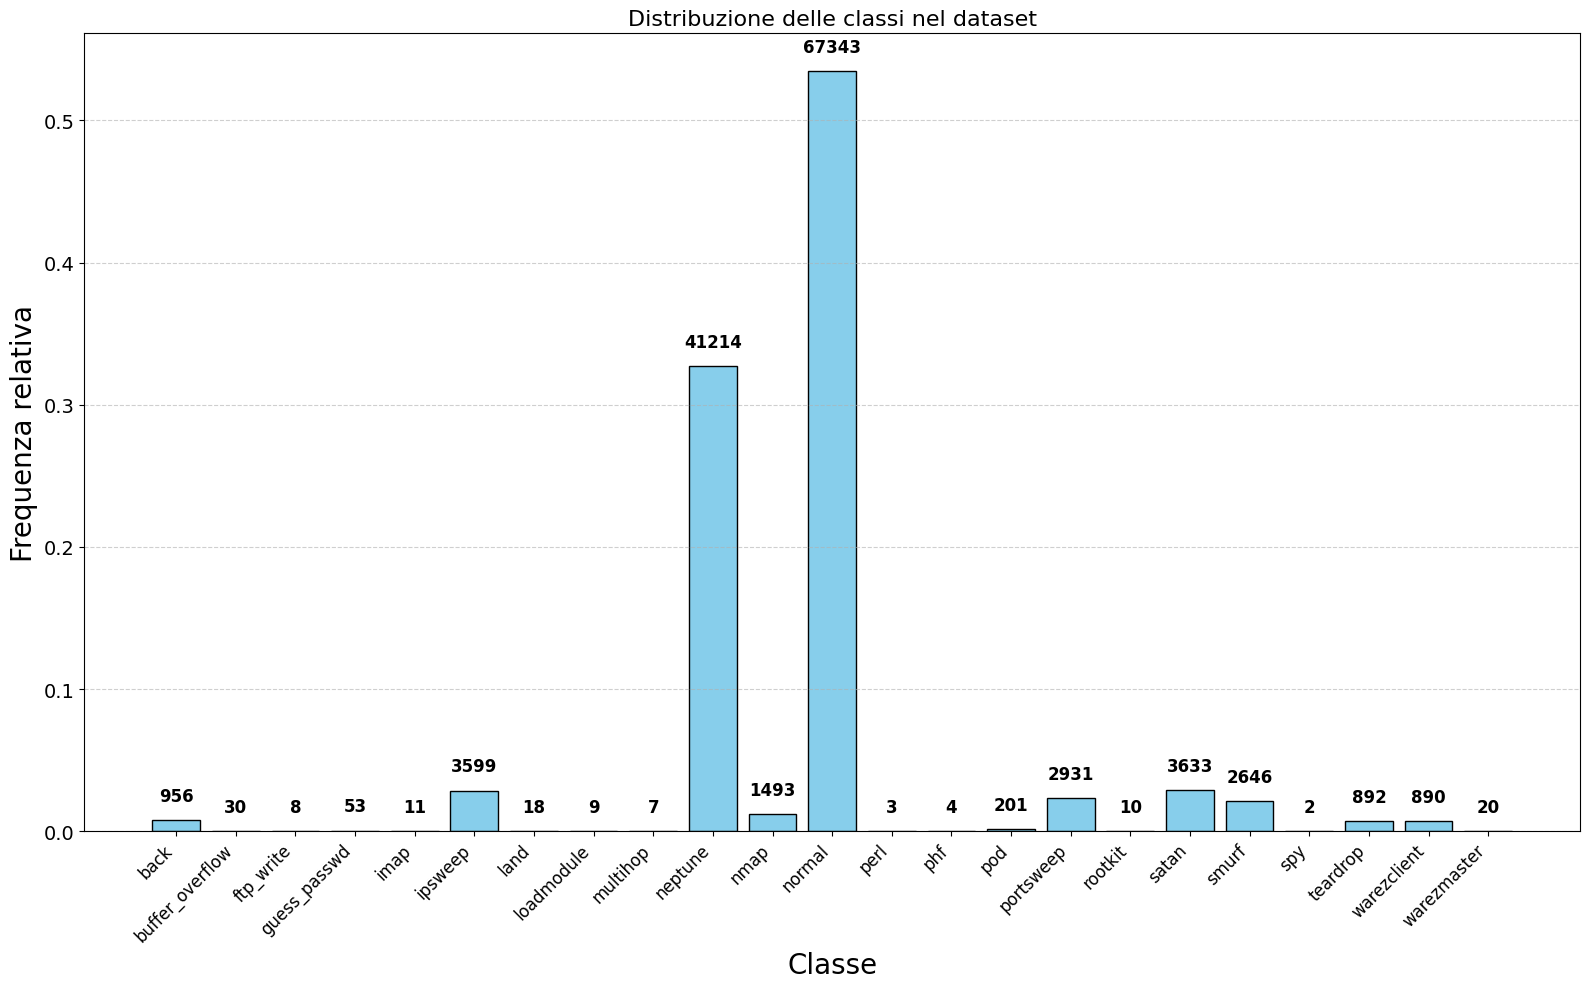

In [80]:
plot_class_distribution(df, y_col='label', string=' nel dataset')

**Normalizzazione**

Nelle seguenti celle di codice viene visualizzato il valore di alcuni sample all'interno del dataset prima e dopo la normalizzazione delle feature. Questa avviene tramite lo **StandardScaler** che imposta a media zero e deviazione standard uno le varie feature.

$$
x_{\text{scaled}} = \frac{x - \mu}{\sigma}
$$

In [81]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [82]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
df_normalized = df.copy()
df_normalized[numeric_cols] = scaler.fit_transform(df_normalized[numeric_cols])

In [83]:
df_normalized.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,-0.110249,tcp,ftp_data,SF,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.818890,-0.782367,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387,normal
1,-0.110249,udp,other,SF,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-1.035688,-1.161030,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,normal
2,-0.110249,tcp,private,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.809857,-0.938287,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,neptune
3,-0.110249,tcp,http,SF,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,...,1.258754,1.066401,-0.439078,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084,normal
4,-0.110249,tcp,http,SF,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,...,1.258754,1.066401,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,normal


**Divisione tra Train e Test set**

Nella cella di codice sottostante avviene uno split train/test stratificato personalizzato per garantire che anche le classi con pochissimi campioni siano rappresentate sia nel training sia nel test set.

In particolare:

* Conta i campioni per ogni classe
* Per le classi con numero di campioni al di sotto di una soglia, estrae manualmente uno o più campioni per garantire la loro presenza nel test set
* Rimuove questi campioni estratti dal dataset principale e li mette da parte
* Sul resto dei dati esegue uno split stratificato standard per preservare la distribuzione delle classi
* Ricompone il training e il test set aggiungendo i campioni "hold-out" estratti manualmente
* Verifica che non ci siano sovrapposizioni tra training e test set, garantendo l'assenza di duplicati tra i due set

In questo modo si ottiene uno split train/test equilibrato anche in presenza di classi estremamente rare.


In [84]:
test_size = 0.2

#Conto i sample per classe
counts = df_normalized['label'].value_counts()

#Preparo liste per i “hold‐out” manuali
test_holds  = []
train_holds = []

for code, cnt in counts.items():
    # se non basterebbe un solo estratto per test_size
    if cnt * test_size < 1:
        df_cls = df_normalized[df_normalized['label'] == code]
        # estraggo 1 per il test
        one_test = df_cls.sample(n=1, random_state=42)
        test_holds.append(one_test)
        # se cnt==2, estraggo 1 anche per il train
        if cnt == 2:
            one_train = df_cls.drop(one_test.index).sample(n=1, random_state=42)
            train_holds.append(one_train)
        # se cnt>2, lascio il resto in df_remaining per stratify

# Concat i DataFrame
test_holds_df = pd.concat(test_holds, ignore_index=False)
train_holds_df = pd.concat(train_holds, ignore_index=False) if train_holds else pd.DataFrame()

# Rimuovo questi hold‐out dal df principale
df_remaining = df_normalized.drop(test_holds_df.index)
if not train_holds_df.empty:
    df_remaining = df_remaining.drop(train_holds_df.index)

# Stratified split sul resto
X_rem = df_remaining.drop(columns=['label'])
y_rem = df_remaining['label']

X_train_rest, X_test_rest, y_train_rest, y_test_rest = train_test_split(
    X_rem, y_rem,
    test_size=test_size,
    stratify=y_rem,
    random_state=42
)

# Ricompongo train e test finali
X_train = pd.concat([X_train_rest, train_holds_df.drop(columns=['label'])], ignore_index=False)
y_train = pd.concat([y_train_rest, train_holds_df['label']],                   ignore_index=False)

X_test  = pd.concat([X_test_rest,  test_holds_df.drop(columns=['label'])],    ignore_index=False)
y_test  = pd.concat([y_test_rest,  test_holds_df['label']],                    ignore_index=False)

# Verifica finale
assert set(X_train.index).isdisjoint(X_test.index), "Overlap tra train/test!"
print("Split OK — tutte le classi piccole (spy, perl, ecc.) garantite in test, stratify senza errori.")

Split OK — tutte le classi piccole (spy, perl, ecc.) garantite in test, stratify senza errori.


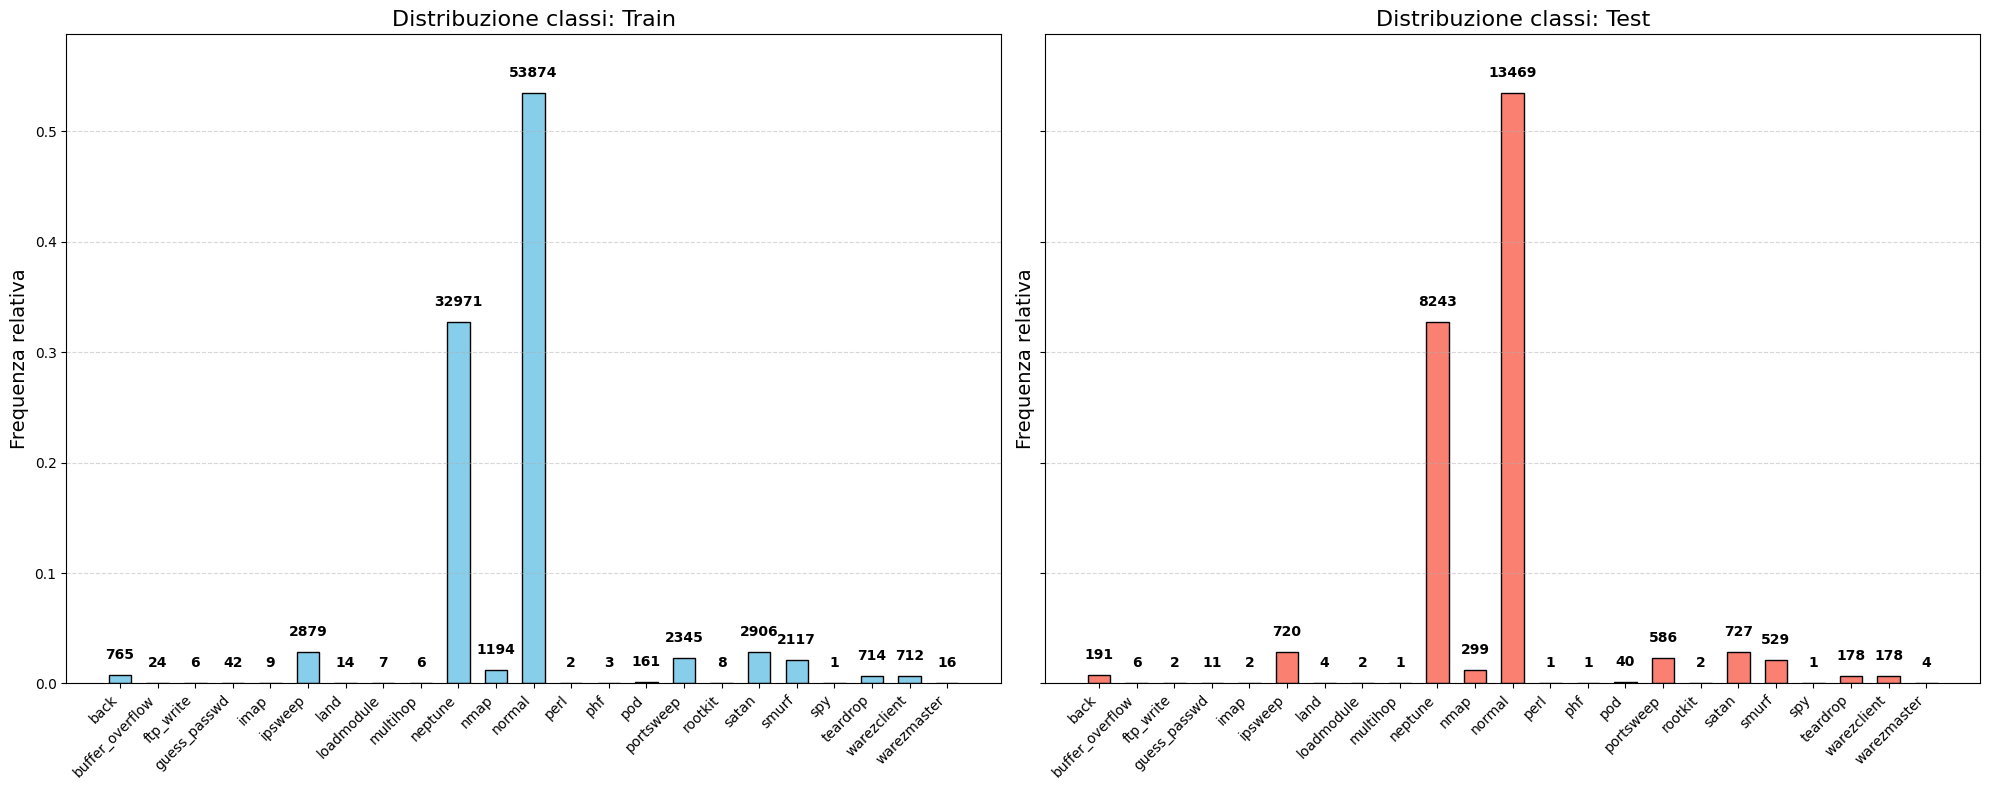

In [85]:
plot_subset_distribution(y_train, y_test, string='Test', label_encoder = None)

In [86]:
feature_col = 'service'
val_to_move = 'http_2784'
print(f"Nuove dimensioni train aumentato: X_train_aug={X_train.shape}, y_train_aug={y_train.shape}")
print(f"Dimensioni test residue: X_test={X_test.shape}, y_test={y_test.shape}")
# Trova gli indici dei campioni da spostare nel test
idx_to_move = X_test[X_test[feature_col] == val_to_move].index
print(f"Indice/i da spostare dal test al train aumentato: {list(idx_to_move)}")

# Estrai i campioni dal test
X_to_move = X_test.loc[idx_to_move]
y_to_move = y_test.loc[idx_to_move]

# Rimuovi dal test
X_test = X_test.drop(idx_to_move)
y_test = y_test.drop(idx_to_move)

# y_train_aug è numpy array converto y_to_move in array per concat
y_to_move_arr = y_to_move.values if hasattr(y_to_move, 'values') else y_to_move

# Aggiungi al train aumentato
X_train_aug = pd.concat([X_train, X_to_move], ignore_index=True)
y_train_aug = np.concatenate([y_train, y_to_move_arr])

# controllo dimensioni
print(f"Nuove dimensioni train aumentato: X_train_aug={X_train.shape}, y_train_aug={y_train.shape}")
print(f"Dimensioni test residue: X_test={X_test.shape}, y_test={y_test.shape}")


Nuove dimensioni train aumentato: X_train_aug=(100776, 40), y_train_aug=(100776,)
Dimensioni test residue: X_test=(25197, 40), y_test=(25197,)
Indice/i da spostare dal test al train aumentato: [45071]
Nuove dimensioni train aumentato: X_train_aug=(100776, 40), y_train_aug=(100776,)
Dimensioni test residue: X_test=(25196, 40), y_test=(25196,)


**Codifica delle colonne categoriche**

Questo codice gestisce la codifica delle colonne categoriche e delle label per preparare i dati all’addestramento del modello.

In dettaglio:

* Vengono individuate le colonne categoriche (`protocol_type`, `service`, `flag`) che contengono dati non numerici.
* Per ciascuna colonna categorica si applica un **Label Encoding**, trasformando le categorie testuali in valori numerici interi, mantenendo invariato il numero di colonne. Questo consente di preservare la struttura originale del dataset senza espandere dimensionalità, utile per modelli che non richiedono one-hot encoding.
* Anche le etichette di classe `y_train` e `y_test` sono convertite in valori interi tramite un `LabelEncoder` separato, standardizzando così il formato delle target variable per l’addestramento.

Questa fase è fondamentale per trasformare dati categorici in un formato numerico interpretabile dai modelli di machine learning.


In [87]:
# Identificare le colonne categoriche
categorical_cols = ['protocol_type', 'service', 'flag']

# Applicare Label Encoding per mantenere il numero di colonne invariato
feature_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    feature_encoders[col] = le

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [88]:
# Per la colonna 'protocol_type'
le_protocol = feature_encoders['protocol_type']
print("="*36)
print(f"Mapping per colonna 'protocol_type':")
print("="*36)
print(f"{'Categoria':<20} | {'Codice':>5}")
print("-" * 36)
for cat, code in zip(le_protocol.classes_, le_protocol.transform(le_protocol.classes_)):
    print(f"{cat:<20} | {code:>5}")
print("="*36)

Mapping per colonna 'protocol_type':
Categoria            | Codice
------------------------------------
icmp                 |     0
tcp                  |     1
udp                  |     2


In [89]:
# Per la colonna 'service'
le_service = feature_encoders['service']
print("="*30)
print(f"Mapping per colonna 'service':")
print("="*30)
print(f"{'Categoria':<20} | {'Codice':>5}")
print("-" * 30)
for cat, code in zip(le_service.classes_, le_service.transform(le_service.classes_)):
    print(f"{cat:<20} | {code:>5}")
print("="*30)

Mapping per colonna 'service':
Categoria            | Codice
------------------------------
IRC                  |     0
X11                  |     1
Z39_50               |     2
aol                  |     3
auth                 |     4
bgp                  |     5
courier              |     6
csnet_ns             |     7
ctf                  |     8
daytime              |     9
discard              |    10
domain               |    11
domain_u             |    12
echo                 |    13
eco_i                |    14
ecr_i                |    15
efs                  |    16
exec                 |    17
finger               |    18
ftp                  |    19
ftp_data             |    20
gopher               |    21
harvest              |    22
hostnames            |    23
http                 |    24
http_443             |    25
http_8001            |    26
imap4                |    27
iso_tsap             |    28
klogin               |    29
kshell               |    30
ldap     

In [90]:
# Per la colonna 'flag'
le_flag = feature_encoders['flag']
print("="*29)
print(f"Mapping per colonna 'flag':")
print("="*29)
print(f"{'Categoria':<20} | {'Codice':>5}")
print("-" * 29)
for cat, code in zip(le_flag.classes_, le_flag.transform(le_flag.classes_)):
    print(f"{cat:<20} | {code:>5}")
print("="*29)

Mapping per colonna 'flag':
Categoria            | Codice
-----------------------------
OTH                  |     0
REJ                  |     1
RSTO                 |     2
RSTOS0               |     3
RSTR                 |     4
S0                   |     5
S1                   |     6
S2                   |     7
S3                   |     8
SF                   |     9
SH                   |    10


In [91]:
print("="*40)
print(f"{'Classe originale':<30} | {'Codice':>6}")
print("-"*40)
for i, cls in enumerate(label_encoder.classes_):
    print(f"{cls:<30} | {i:>6}")
print("="*40)

Classe originale               | Codice
----------------------------------------
back                           |      0
buffer_overflow                |      1
ftp_write                      |      2
guess_passwd                   |      3
imap                           |      4
ipsweep                        |      5
land                           |      6
loadmodule                     |      7
multihop                       |      8
neptune                        |      9
nmap                           |     10
normal                         |     11
perl                           |     12
phf                            |     13
pod                            |     14
portsweep                      |     15
rootkit                        |     16
satan                          |     17
smurf                          |     18
spy                            |     19
teardrop                       |     20
warezclient                    |     21
warezmaster                    |     22

**Dimensionality Reduction**

La cella sottostante calcola la matrice di correlazione tra le feature per poi eliminare quelle con un indice di correlazione maggiore di una threshold. La scelta di quale feature eliminare avviene secondo il principio di ridondanza complessiva ovvero tra due feature fortemente correlate, viene rimossa quella che risulta mediamente più correlata con tutte le altre feature del dataset.


$$
X_k \quad \text{dove} \quad k = \arg\max_{m \in \{i,j\}} \left( \frac{1}{p-1} \sum_{\substack{l=1 \\ l \neq m}}^{p} | \text{corr}(X_m, X_l) | \right)
$$

Dove:

* $p$ è il numero totale di feature nel dataset,
* $\text{corr}(X_m, X_l)$ è il coefficiente di correlazione tra la feature $X_m$ e la feature $X_l$,
* il termine tra parentesi rappresenta la **media delle correlazioni assolute** di $X_m$ con tutte le altre feature (esclusa se stessa).

In pratica, si elimina la feature $X_k$ che ha la media di correlazione più alta con tutte le altre feature, cioè quella più ridondante rispetto all’intero insieme di variabili.

Dropping 5 redundant features (pairwise corr > 0.975):
{'srv_serror_rate', 'dst_host_serror_rate', 'num_root', 'srv_rerror_rate', 'dst_host_srv_serror_rate'}
Shape dopo feature-selection:
X_train_final: (100776, 35)
X_test_final:  (25196, 35)


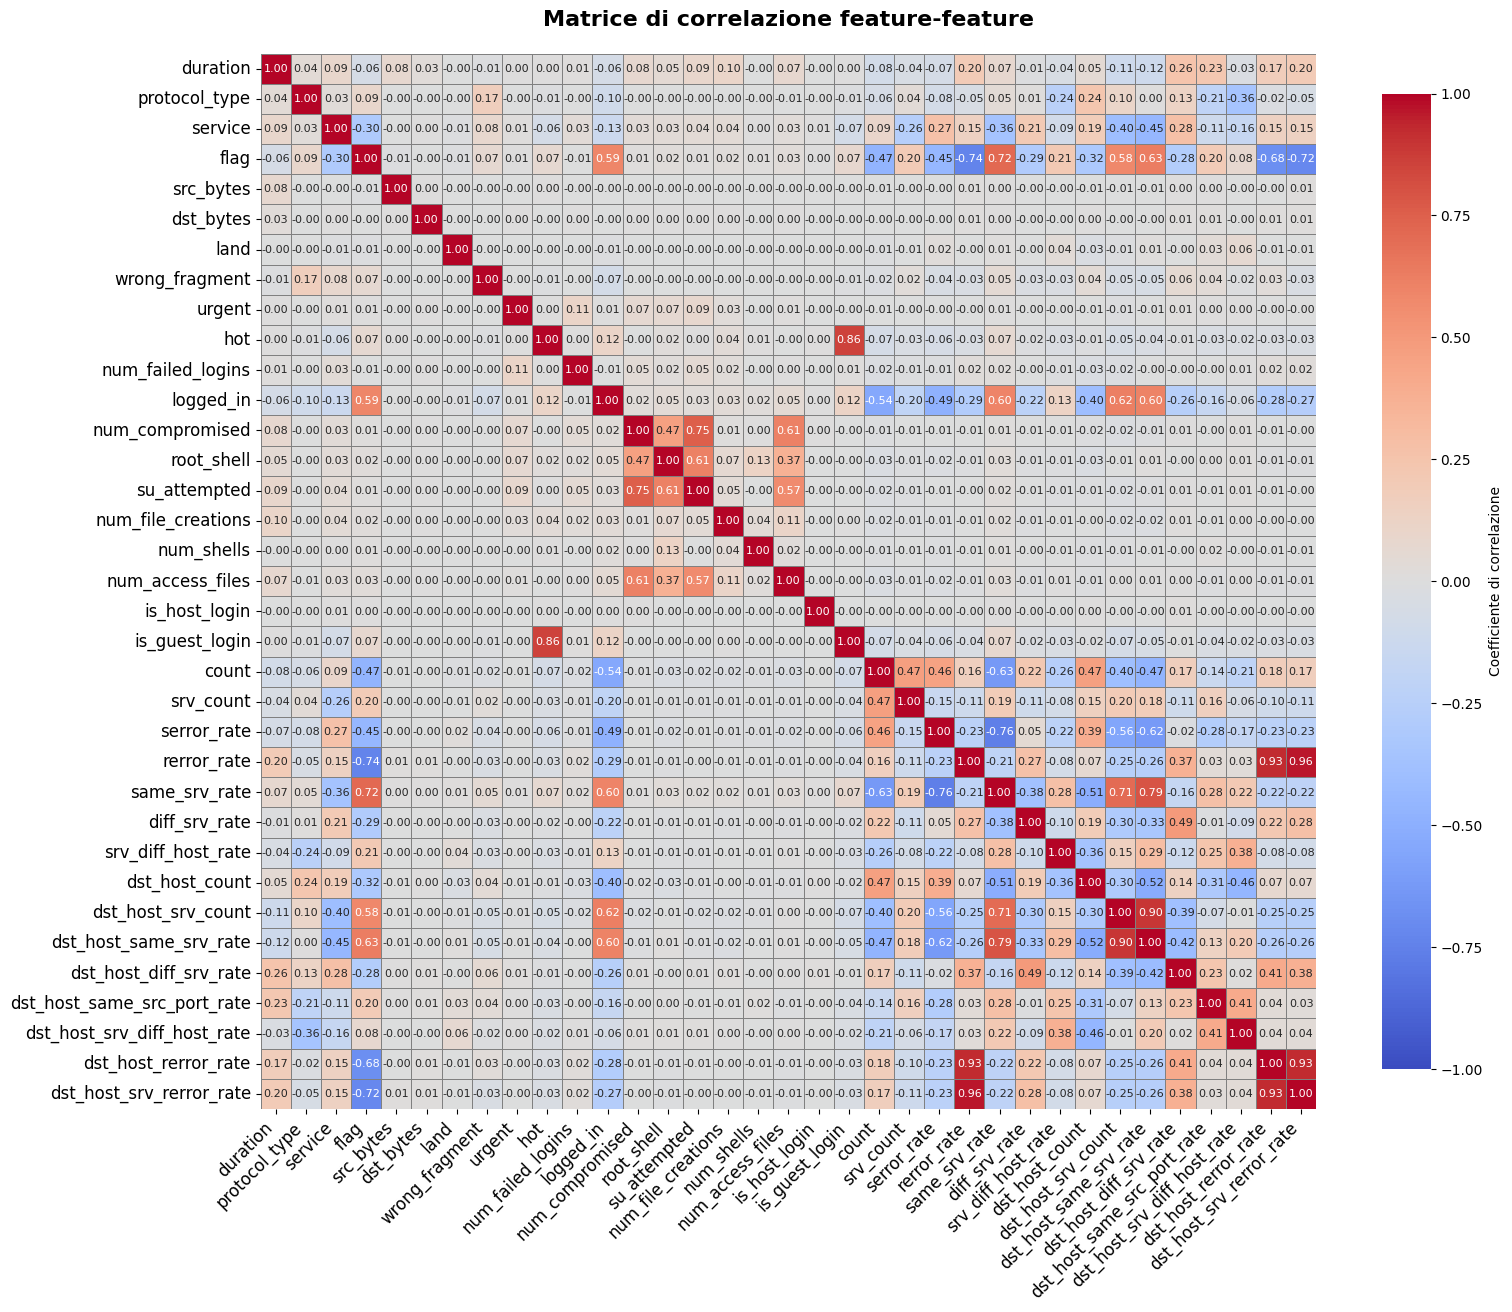

In [92]:
#Soglia di ridondanza feature–feature
threshold_redundancy = 0.975

# Calcolo matrice di correlazione assoluta sulle feature rimaste
corr_matrix = X_train.corr().abs()

# Mantengo solo triangolo superiore (senza diagonale)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = set()
# Per ogni coppia (row, col) con corr > threshold_redundancy
for col in upper_tri.columns:
    for row in upper_tri.index:
        val = upper_tri.loc[row, col]
        if pd.isna(val) or val <= threshold_redundancy:
            continue
        # confronto la "ridondanza media" delle due feature
        mean_row = corr_matrix[row].drop(row).mean()
        mean_col = corr_matrix[col].drop(col).mean()
        # scarto quella con media corr più alta
        drop_feat = row if mean_row > mean_col else col
        to_drop.add(drop_feat)

print(f"Dropping {len(to_drop)} redundant features (pairwise corr > {threshold_redundancy}):")
print(to_drop)

X_train = X_train.drop(columns=list(to_drop))
X_test  = X_test.drop(columns=list(to_drop))

print("Shape dopo feature-selection:")
print("X_train_final:", X_train.shape)
print("X_test_final: ", X_test.shape)


plt.figure(figsize=(16, 14))

sns.heatmap(
    X_train.corr(),
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5,
    linecolor='gray',
    annot=True,                # aggiunge i numeri nelle celle
    fmt=".2f",                 # formato numerico con 2 decimali
    annot_kws={"size": 8},     # dimensione font annotazioni
    cbar_kws={"shrink": 0.8, 'label': 'Coefficiente di correlazione'}
)

plt.title("Matrice di correlazione feature-feature", fontsize=16, weight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

**Data augmentation**

Il codice implementa una strategia di bilanciamento delle classi minoritarie nel dataset di training tramite oversampling selettivo con rumore. Per ogni classe con un numero di samples inferiore a una soglia, vengono creati nuovi campioni sintetici duplicando dati esistenti per poi applicare un rumore gaussiano contenuto solo sulle feature numeriche, in modo da non generare nuovi sample vicini a quelli reali.

L'introduzione di nuovi samples è necessaria per la suddivisione in Training e Validation set poichè alcune classi minoritarie prima di questo procedimento, in alcuni casi, contavano 1 sample.


In [93]:
num_cols = [c for c in X_train.columns if c not in categorical_cols]

X_train_orig = X_train.copy()
y_train_orig = y_train.copy()
#Oversampling “jitter” sulle sole numeriche
threshold, jitter_scale = 6, 0.01
counts = Counter(y_train)
aug_X, aug_y = [], []

for cls, cnt in counts.items():
    if cnt < threshold:
        Xc = X_train[y_train == cls]
        Xc_num = Xc[num_cols].reset_index(drop=True)
        Xc_cat = Xc[categorical_cols].reset_index(drop=True)

        to_add = threshold - cnt
        idx = np.random.choice(Xc_num.index, size=to_add, replace=True)
        dup_num = Xc_num.loc[idx].reset_index(drop=True)
        dup_cat = Xc_cat.loc[idx].reset_index(drop=True)

        noise = np.random.normal(0, jitter_scale, size=dup_num.shape)
        dup_num = dup_num + noise

        dup = pd.concat([dup_num, dup_cat], axis=1)[X_train.columns]
        aug_X.append(dup)
        aug_y.append(pd.Series([cls]*to_add, name='label'))

#Ricompone
X_train_aug = pd.concat([X_train.reset_index(drop=True)] + aug_X,
                        ignore_index=True)
y_train_aug = np.concatenate([y_train] + aug_y)

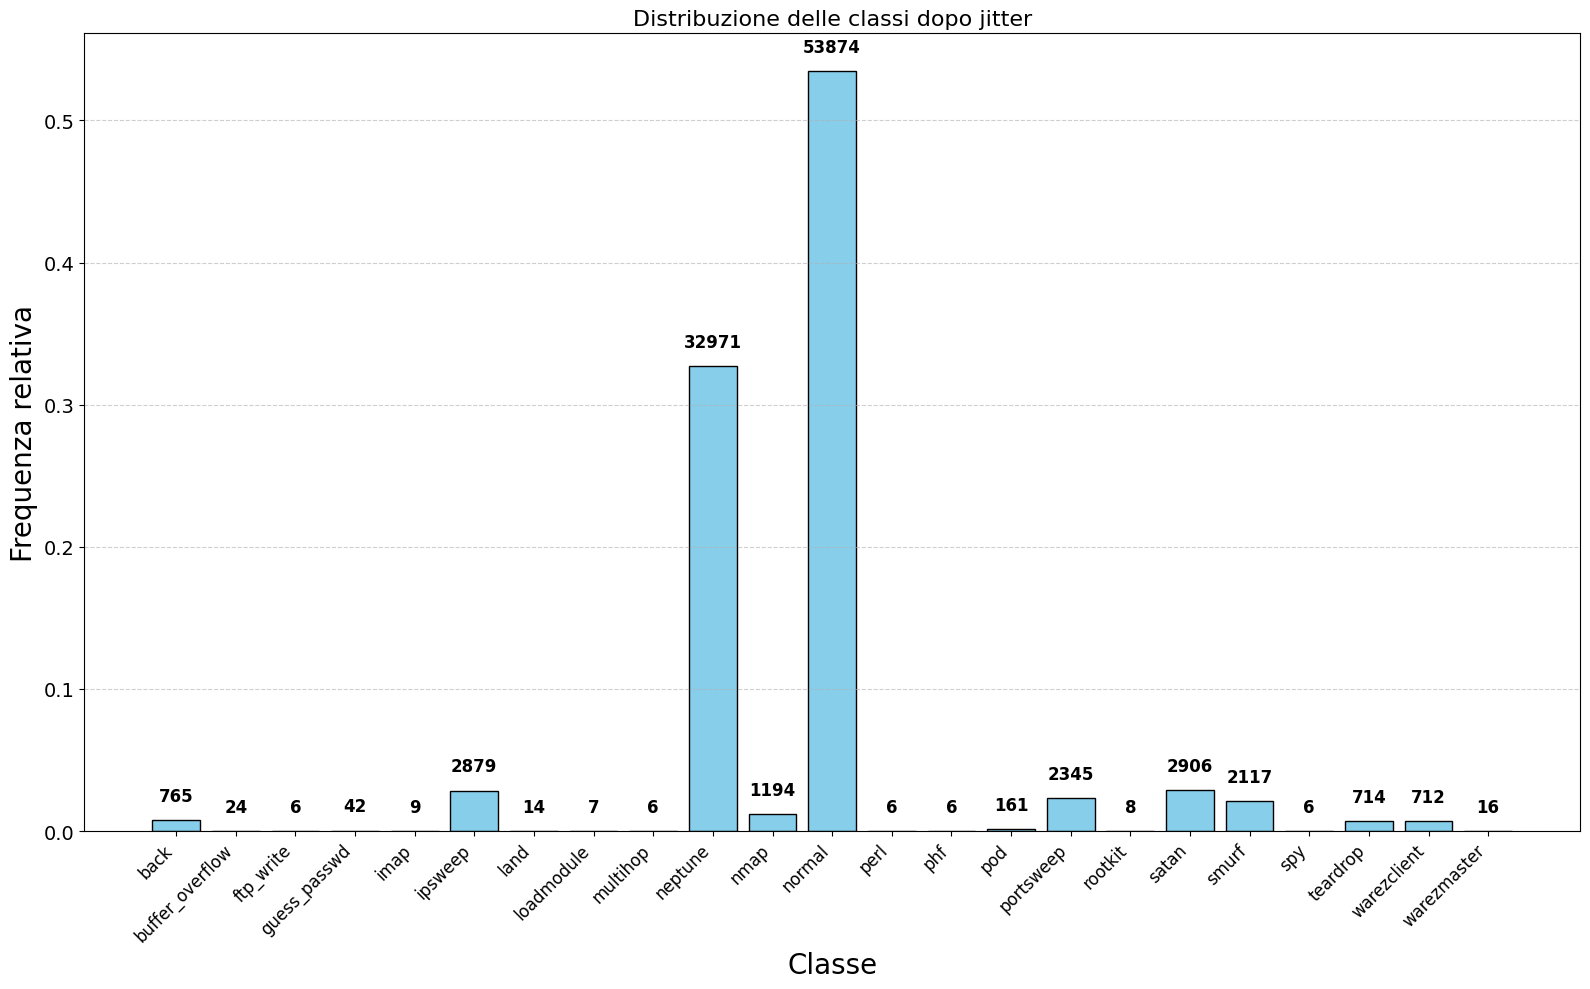

In [94]:
plot_class_distribution(y_train_aug,string=' dopo jitter', label_encoder=label_encoder)

Viene effettuato la suddivisone in Training e Validation set per poi verificare la distribuzione nei subsets

In [95]:
X_train_to_smote, X_val, y_train_to_smote, y_val = train_test_split(X_train_aug, y_train_aug, test_size=1/6, stratify=y_train_aug, random_state=42)

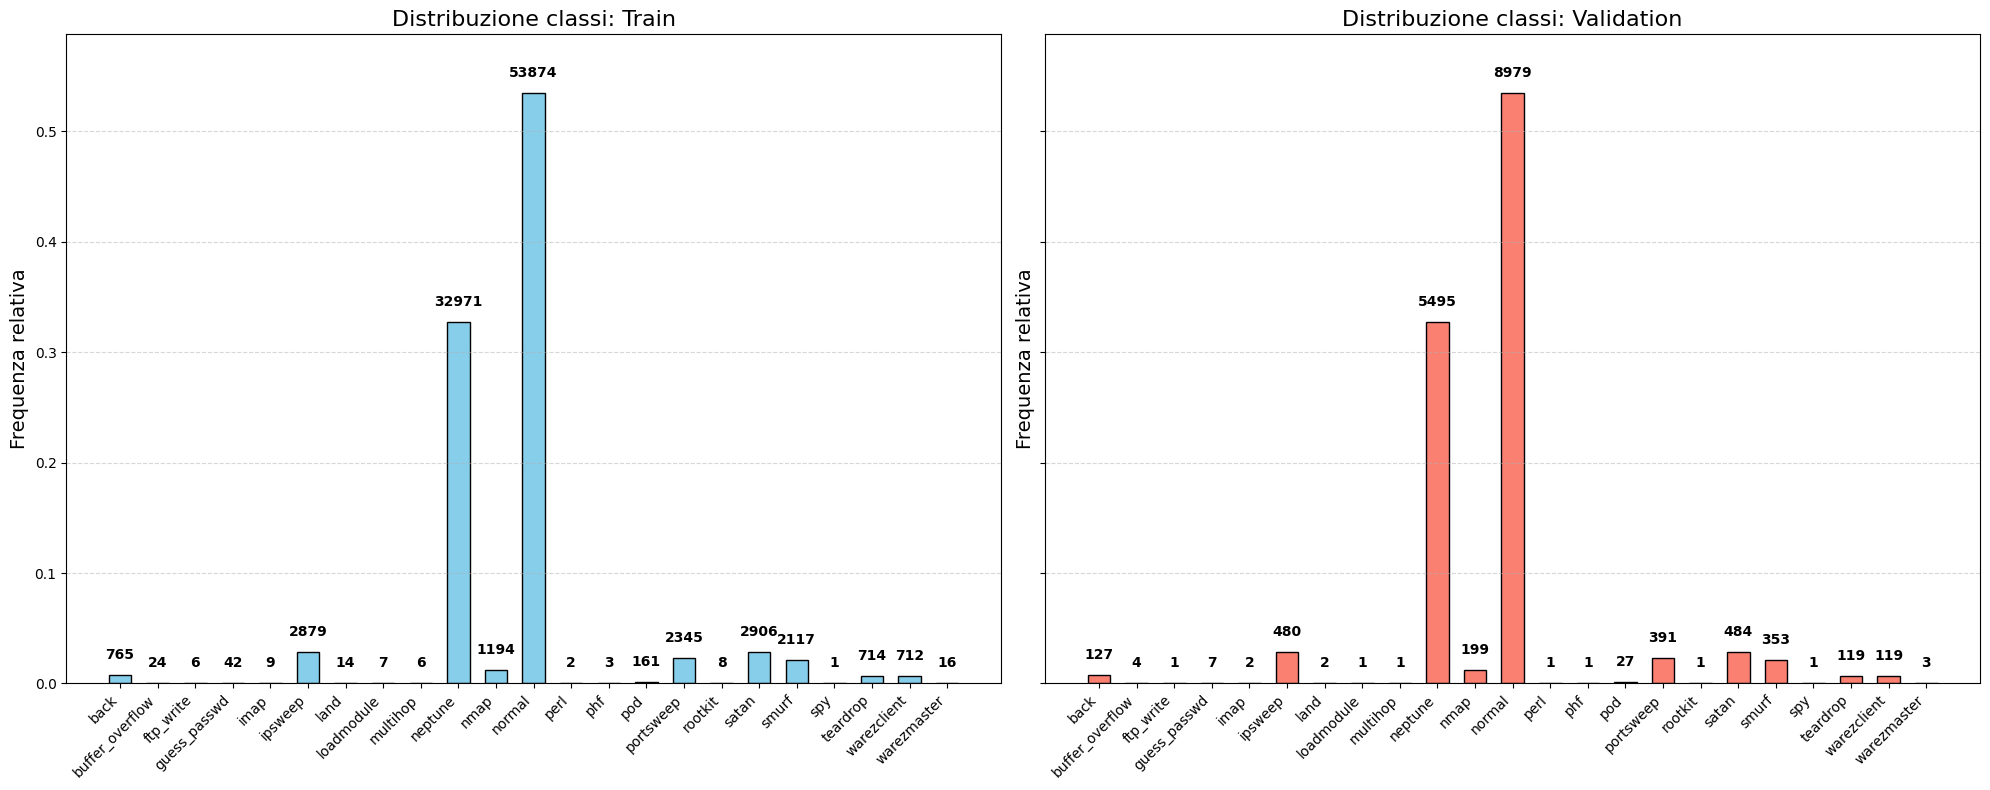

In [96]:
plot_subset_distribution(y_train, y_val, string='Validation',label_encoder=label_encoder)

**Calcolo dei pesi**

La funzione `compute_weights_by_occurrence` calcola un peso per ciascuna classe in base alla formula sottostante:

$$
\text{Peso} = \min(\text{minimo}, (\frac{\text{max count}}{\text{count}})^{\frac{1}{3}})
$$

Dove:

* `max_count` è il numero totale di samples.
* `count` è il numero di samples per una specifica classe.
* Il risultato viene ridotto a una soglia definita da `minimo` per evitare che il peso cresca troppo per classi molto rare.

Questo approccio è utile per migliorare le performance dei modelli su dataset sbilanciati, garantendo che le classi minoritarie ricevano più attenzione durante l'addestramento.

In [ ]:
def compute_weights_by_occurrence(y,minimo):
    counts = Counter(y)
    max_count = max(counts.values())
    return {cls: min(minimo, (max_count / count)**(1/3)) for cls, count in counts.items()}


def print_class_weights(y, weights):
    counts = Counter(y)
    # dimensioni colonne
    w_name = 17
    w_cnt  = 12
    w_wgt  = 10
    total_width = w_name + w_cnt + w_wgt + 2 * 3  # " | " tra le 3 colonne

    # bordo superiore
    print("=" * total_width)
    # header
    print(f"{'Classe originale':<{17}} | "f"{'Occorrenze':>{12}} | "f"{'Peso':>{w_wgt}}")
    # separatore
    print("-" * total_width)

    # righe
    for code in sorted(weights):
        orig_name = label_encoder.classes_[code]
        count     = counts.get(code, 0)
        weight    = weights[code]
        print(f"{orig_name:<{w_name}} | "f"{count:>{w_cnt}} | "f"{weight:>{w_wgt}.4f}")

    # bordo inferiore
    print("=" * total_width)


weights = compute_weights_by_occurrence(y_train,10)

print_class_weights(y_train, weights)

alpha_vec = np.array([weights[c] for c in range(23)], dtype=np.float32)

Classe originale  |   Occorrenze |       Peso
---------------------------------------------
back              |          765 |     4.1296
buffer_overflow   |           24 |    10.0000
ftp_write         |            6 |    10.0000
guess_passwd      |           42 |    10.0000
imap              |            9 |    10.0000
ipsweep           |         2879 |     2.6549
land              |           14 |    10.0000
loadmodule        |            7 |    10.0000
multihop          |            6 |    10.0000
neptune           |        32971 |     1.1778
nmap              |         1194 |     3.5601
normal            |        53874 |     1.0000
perl              |            2 |    10.0000
phf               |            3 |    10.0000
pod               |          161 |     6.9425
portsweep         |         2345 |     2.8428
rootkit           |            8 |    10.0000
satan             |         2906 |     2.6466
smurf             |         2117 |     2.9414
spy               |            1 |

**SMOTENC**

Il codice applica un oversampling dinamico per bilanciare il Training set, focalizzandosi sulle classi meno rappresentate. Per ciascuna classe con meno di 7 esempi, viene applicato un fattore di moltiplicazione pari a 2, mentre per quelle con meno di 10 esempi il fattore è 3.

Viene utilizzato SMOTENC come oversampler per generare campioni sintetici, in modo da non toccare le feature categoriche durante l'operazione, e il dataset viene bilanciato leggermente senza modificarne troppo la distribuzione fornendo ai modelli più esempi delle classi difficili da comprendere migliorando l'addestramento.

In [ ]:
y_series = pd.Series(y_train_to_smote, name="label")

# Calcolo le occorrenze per classe
class_counts = y_series.value_counts()

#Parametri di oversampling dinamico
#se cnt < threshold1 → moltiplica per factor1
#elif cnt < threshold2 → moltiplica per factor2
#altrimenti non oversampli
threshold1, factor1 = 7, 2
threshold2, factor2 = 10, 3

sampling_strategy = {}
for lbl, cnt in class_counts.items():
    if cnt < threshold1:
        target = cnt * factor1
    elif cnt < threshold2:
        target = cnt * factor2
    else:
        continue
    # inserisco solo se sto effettivamente aumentando
    if target > cnt:
        sampling_strategy[lbl] = target


#Calcolo k_neighbors in modo da non eccedere il minimo numero di vicini disponibili
min_cnt = class_counts.min()
k_neighbors = max(1, min(5, min_cnt - 1))

#Istanzio SMOTENC con la mapping strategy dinamica
smote_nc = SMOTENC(
    categorical_features=num_cols,
    sampling_strategy=sampling_strategy,
    k_neighbors=k_neighbors,
    random_state=42
)

#Applico SMOTENC
X_train, y_train = smote_nc.fit_resample(X_train_to_smote, y_train_to_smote)

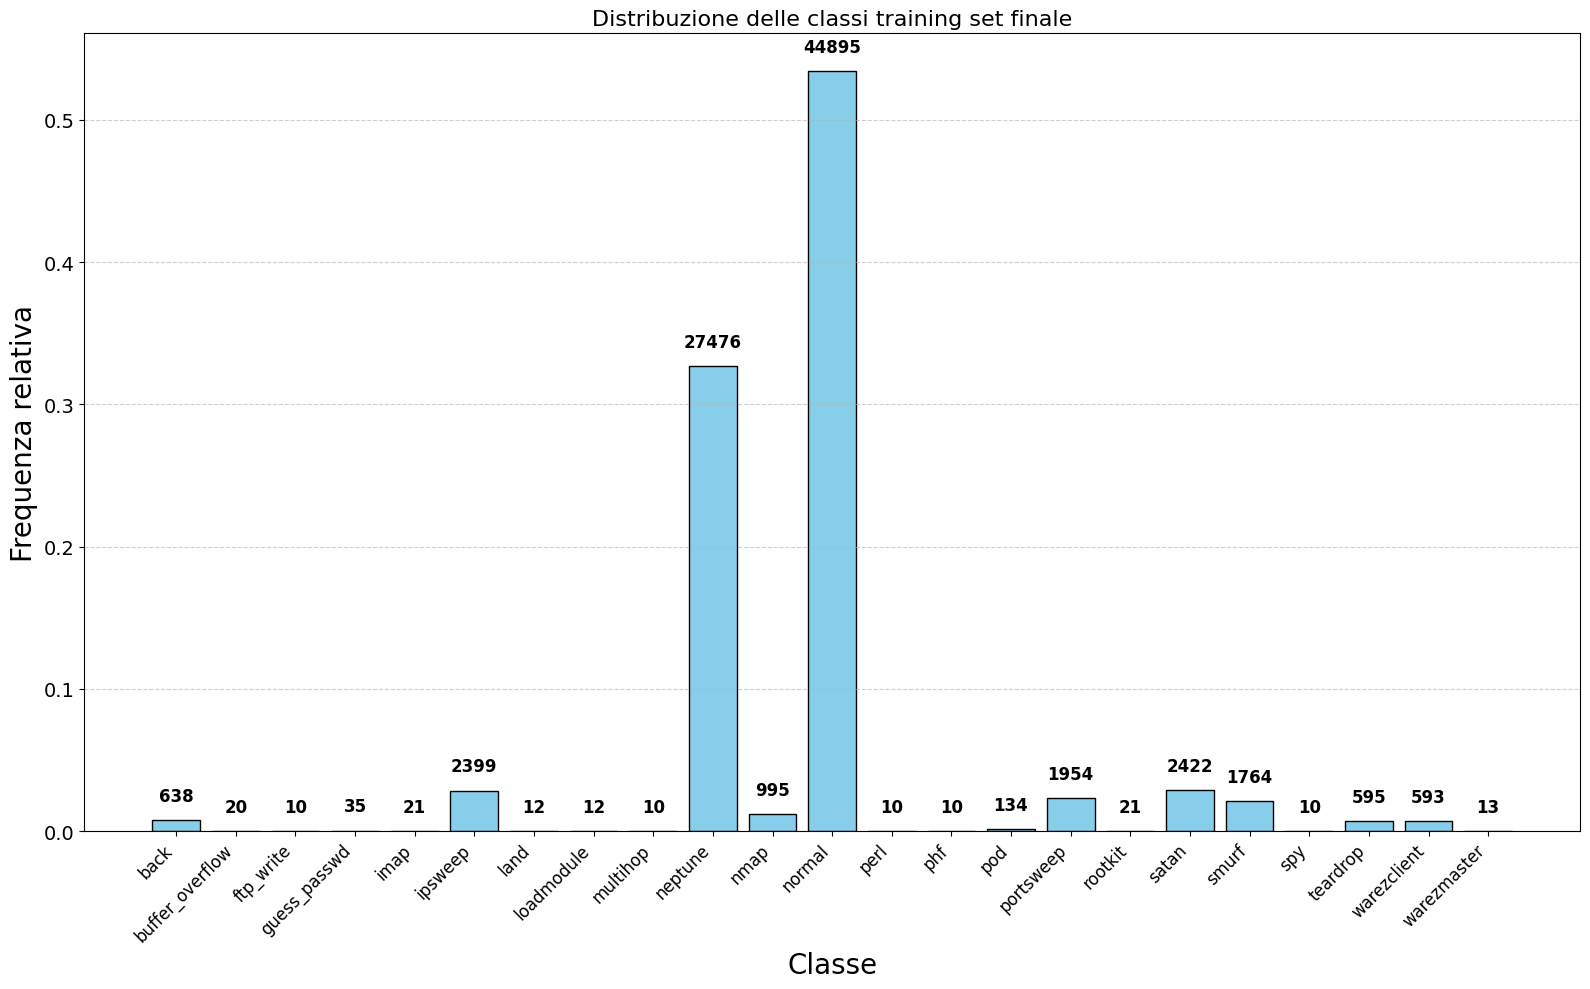

In [63]:
plot_class_distribution(y_train, string=' training set finale', label_encoder=label_encoder)

In [ ]:

class DynamicSMOTENC(SMOTENC):
   
    #SMOTENC che ad ogni fit_resample abbassa k_neighbors se nel fold corrente la classe-minoranza è troppo piccola.
  
    def fit_resample(self, X, y):
        # Conto i campioni per classe in questo fold
        min_cnt = pd.Series(y).value_counts().min()
        # k non può superare (min_cnt - 1) e deve essere ≥1
        k_safe = max(1, min(self.k_neighbors, min_cnt - 1))
        if k_safe != self.k_neighbors:          # se serve riduci
            self.k_neighbors = k_safe
        return super().fit_resample(X, y)

#istanzio
cat_cols    = ['protocol_type', 'service', 'flag']
cat_indices = [X_train_aug.columns.get_loc(c) for c in cat_cols]

dynamic_smote = DynamicSMOTENC(
    categorical_features=cat_indices,
    sampling_strategy=sampling_strategy,   # la tua mapping dinamica
    k_neighbors=5,                         # valore massimo desiderato
    random_state=42
)



# RANDOM FOREST

**Definizione e Training Random Forest**

Il modello Random Forest è stato inserito all’interno di una pipeline. Tramite l'uso di dynamic SMOTENC si applica oversampling per bilanciare le classi nel dataset di training per migliorare la capacità predittiva anche delle classi minoritarie evitando data leakage.

L'ottimizzazione della Random Forest avviene tramite GridSearch sui seguenti iperparametri:

* `n_estimators`: numero di alberi presenti nella foresta.
* `max_depth`: profondità massima consentita per ciascun albero.
* `min_samples_split`: numero minimo di campioni necessari per effettuare uno split interno.
* `min_samples_leaf`: numero minimo di campioni richiesti in un nodo foglia.
* `max_features`: numero di feature considerate per ogni split. L'opzione `sqrt` (radice quadrata del totale) e 0.5 (metà del totale), aiutano ad aumentare la diversità degli alberi.
* `bootstrap`: booleano che indica la campionatura con rimpiazzo nel set.

La validazione incrociata è stata adottata per stimare in modo affidabile la capacità predittiva del modello, utilizzando come metrica di valutazione il punteggio F1 macro, particolarmente indicato in problemi con classi sbilanciate poiché considera equamente ogni classe eseguendo una media aritmetica dei valori delle singole classi.

Al termine della ricerca, vengono restituiti il miglior punteggio medio F1 macro e la configurazione degli iperparametri che ottimizzano la Random Forest.

In [ ]:
pipeline = Pipeline([
    ('smote',dynamic_smote
    ),
    ('rf', RandomForestClassifier(
        random_state=42,
        class_weight='balanced'
    ))
])

param_grid = {   #per ottimizzare gli iperparam
    'rf__n_estimators':      [100, 150, 200],
    'rf__max_depth':         [10, 12, None],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf':  [2, 4],
    'rf__max_features':      ['sqrt', 0.5],
    'rf__bootstrap':         [True,False],
}

#Imposto GridSearchCV su X_train_aug/y_train_aug
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=4,                  
    scoring='f1_macro',    # valutazione interna
    n_jobs=-1,
    verbose=2
)

# Fit su train augmentato (senza X_val)
grid_search.fit(X_train_aug, y_train_aug)

#Performance di CV 
print(f"Mean CV F1‑macro: {grid_search.best_score_:.3f}")
print("Best params:", grid_search.best_params_)

#Miglior estimatore
best_rf = grid_search.best_estimator_


Fitting 4 folds for each of 144 candidates, totalling 576 fits
Mean CV F1‑macro: 0.815
Best params: {'rf__bootstrap': False, 'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}


**Cross validation miglior modello**

Per garantire una valutazione solida e affidabile delle performance del modello `best_rf`, si è adottata una validazione incrociata stratificata a 4 fold mediante `StratifiedKFold`.

Durante la cross-validation, vengono calcolati L'**Accuracy**, la **F1 macro**, la **Precision** ed infine la **Recall** su ogni fold.

Infine vengono calcolate le predizioni per il Test set misurando così le sue performance reali.

In [ ]:
#CV “esterno” di performance per misurarle in maniera indipendente dal tuning
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
scoring = {
    'accuracy':        'accuracy',
    'f1_macro':        'f1_macro',
    'precision_macro': 'precision_macro',
    'recall_macro':    'recall_macro'
}

scores = cross_validate(
    best_rf,
    X_train_aug, y_train_aug,
    cv=cv,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# Creazione DataFrame con risultati CV
df_cv = pd.DataFrame({
    'Accuracy':        scores['test_accuracy'],
    'F1 Macro':        scores['test_f1_macro'],
    'Precision Macro': scores['test_precision_macro'],
    'Recall Macro':    scores['test_recall_macro']
})

print("\n=== Metriche di Cross-Validation (4-fold) per ogni fold ===")
print(df_cv.to_string(index=False))

mean_scores = df_cv.mean().to_frame(name='Mean').transpose()
print("\n=== Valori medi della Cross-Validation ===")
print(mean_scores.to_string())

# Valutazione finale sul test set
y_test_pred = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

print("\n=== Valutazione finale sul Test Set ===")
print(f"Accuracy:      {test_accuracy:.4f}")
print(f"F1 Macro:      {test_f1_macro:.4f}")
print(f"F1 Weighted:   {test_f1_weighted:.4f}")




=== Metriche di Cross-Validation (4-fold) per ogni fold ===
 Accuracy  F1 Macro  Precision Macro  Recall Macro
 0.998293  0.831831         0.870844      0.816113
 0.998214  0.854982         0.879545      0.860406
 0.998016  0.815581         0.846046      0.804487
 0.997936  0.856827         0.852438      0.871273

=== Valori medi della Cross-Validation ===
      Accuracy  F1 Macro  Precision Macro  Recall Macro
Mean  0.998115  0.839805         0.862218       0.83807

=== Valutazione finale sul Test Set ===
Accuracy:      0.9981
F1 Macro:      0.7937
F1 Weighted:   0.9980


**Performance della Random Forest sul test set**

Successivamente vengono calcolate e visualizzate le performance del modello sulle singole classi e la corrispettiva matrice di confusione normalizzata del modello Random Forest valutato sul set di test.

In [ ]:
# Classification report come dict
report_dict = classification_report(
    y_test,
    y_test_pred,
    target_names=label_encoder.classes_,
    output_dict=True,
    zero_division=0,  # Imposta precision/recall a 0 invece di lanciare warning
    digits=4 
)

# Converto in DataFrame e trasponi
df_report = pd.DataFrame(report_dict).transpose()

# Separo le righe delle classi da quelle generali
class_rows = [c for c in df_report.index if c not in ('accuracy', 'macro avg', 'weighted avg')]
general_rows = ['accuracy', 'macro avg', 'weighted avg']

# Estraggo colonne di interesse per le classi
class_cols = ['precision', 'recall', 'f1-score', 'support']
df_classes = df_report.loc[class_rows, class_cols].round(6)

# Estraggo tutte le colonne per le righe generali
df_general = df_report.loc[general_rows].round(6)

# Stampo tutto con titoli separati
print("=== Classification Report per classe ===")
print(df_classes)
print("\n=== Metriche generali ===")
print(df_general)


=== Classification Report per classe ===
                 precision    recall  f1-score  support
back              1.000000  1.000000  1.000000    191.0
buffer_overflow   1.000000  0.833333  0.909091      6.0
ftp_write         0.000000  0.000000  0.000000      2.0
guess_passwd      1.000000  1.000000  1.000000     11.0
imap              1.000000  1.000000  1.000000      2.0
ipsweep           0.990305  0.993056  0.991678    720.0
land              0.800000  1.000000  0.888889      4.0
loadmodule        1.000000  0.500000  0.666667      2.0
multihop          0.000000  0.000000  0.000000      1.0
neptune           1.000000  1.000000  1.000000   8243.0
nmap              0.980066  0.986622  0.983333    299.0
normal            0.998367  0.998812  0.998590  13469.0
perl              1.000000  1.000000  1.000000      1.0
phf               1.000000  1.000000  1.000000      1.0
pod               1.000000  1.000000  1.000000     40.0
portsweep         1.000000  0.994881  0.997434    586.0
rootkit

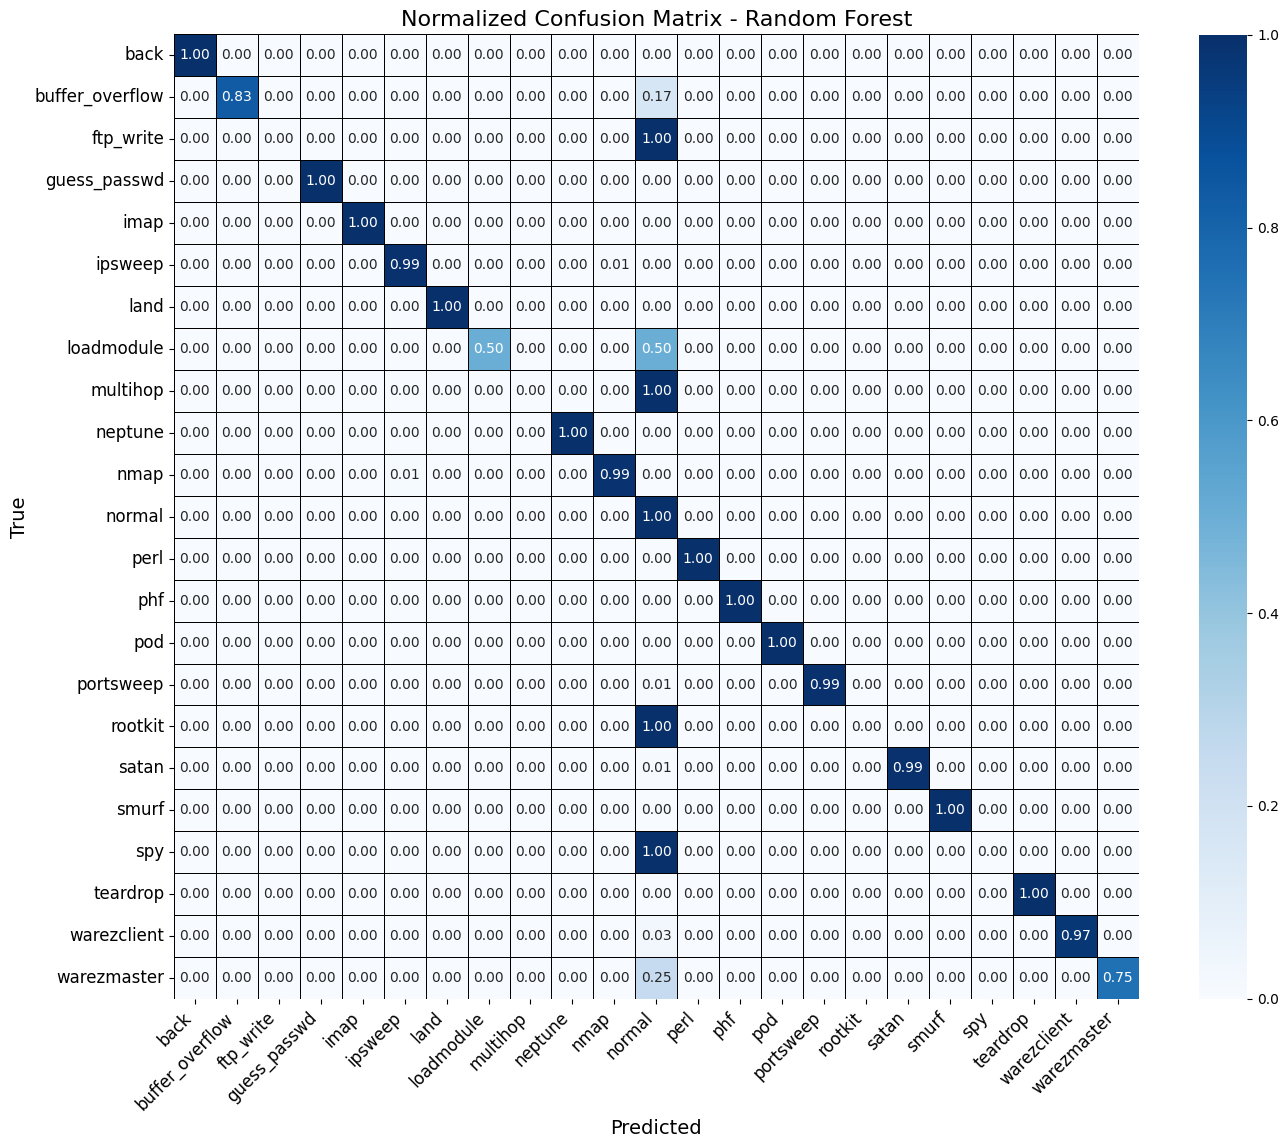

In [ ]:
# Calcolo le predizioni su test
y_pred = best_rf.predict(X_test)

# Lista nomi classi
class_names = best_rf.classes_

# Calcola matrice di confusione e normalizzo
cm = confusion_matrix(y_test, y_pred, labels=class_names)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            annot_kws={'size': 10},
            cbar_kws={'shrink': 0.91},
            linewidths=0.5, linecolor='black',
            square=True)

plt.title("Normalized Confusion Matrix - Random Forest", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

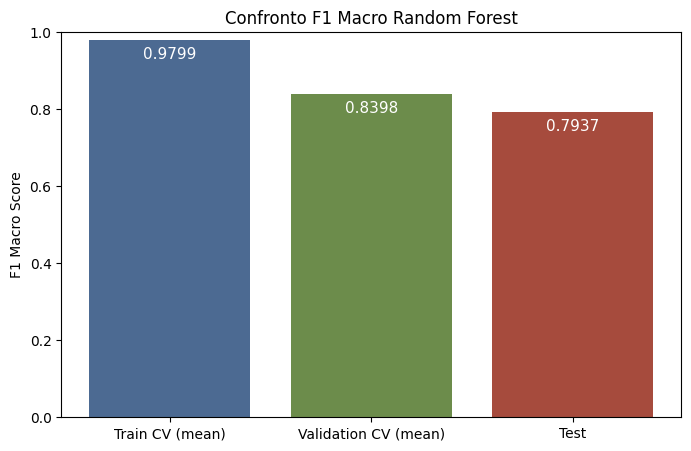

In [ ]:
#Calcolo F1 macro sul training set
y_train_pred = best_rf.predict(X_train_aug)
f1_train = f1_score(y_train_aug, y_train_pred, average='macro')

#Calcolo F1 macro con cross-validation sul training set
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
cv_results = cross_validate(
    best_rf,
    X_train_aug,
    y_train_aug,
    cv=cv,
    scoring='f1_macro',
    return_train_score=True,
    n_jobs=-1
)
f1_train_cv_mean = cv_results['train_score'].mean()
f1_val_cv_mean = cv_results['test_score'].mean()

# Calcolo F1 macro sul test set
y_test_pred = best_rf.predict(X_test)
f1_test = f1_score(y_test, y_test_pred, average='macro')

# Dati per il grafico
labels = ['Train CV (mean)', 'Validation CV (mean)', 'Test']
scores = [f1_train_cv_mean, f1_val_cv_mean, f1_test]

# Plotto
plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['#4C6A92', '#6C8C4B', '#A64B3D'])
plt.ylim(0,1)
plt.ylabel('F1 Macro Score')
plt.title('Confronto F1 Macro Random Forest')

# leggenda
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height - 0.05, f'{height:.4f}', ha='center', color='white', fontsize=11)

plt.show()


**Importanza delle features**

Infine si visualizza l’importanza di ciascuna feature utilizzata nell’addestramento del modello. Le feature sono ordinate in modo decrescente in base al loro contributo nel processo decisionale della foresta. Il grafico a barre individua quali variabili hanno maggiore influenza nell'attività di predizione.

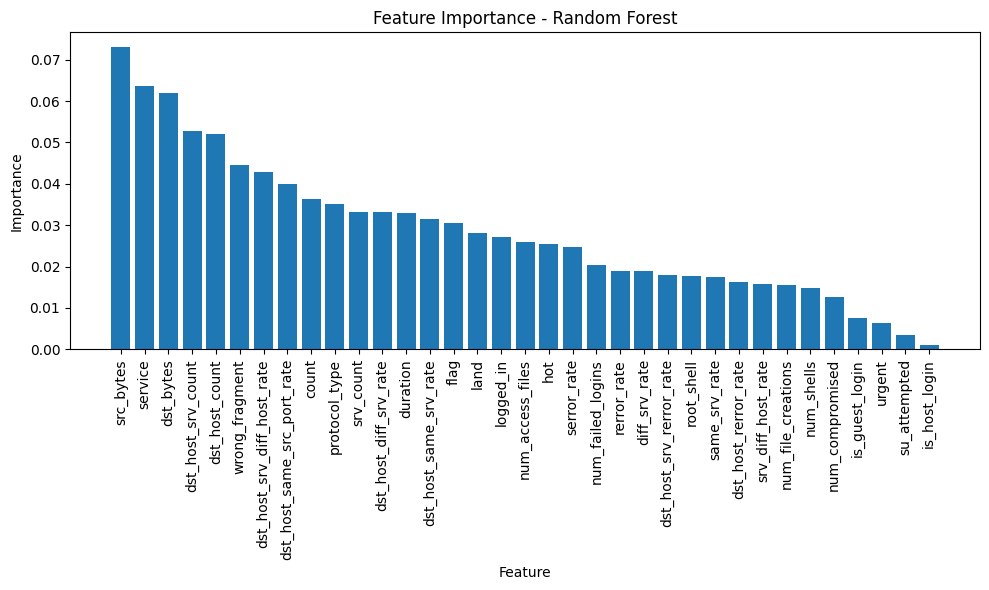

In [ ]:
# Estraggo il modello Random Forest dalla pipeline
rf_model = best_rf.named_steps['rf']

# feature importances
importances = rf_model.feature_importances_


feature_names = X_train_aug.columns if hasattr(X_train_aug, 'columns') else [f'feat_{i}' for i in range(len(importances))]

# Ordino feature per importanza decrescente
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Random Forest")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


# LOGISTIC REGRESSION

**Definizione e Training Logistic Regression**

Il modello **Logistic Regression** è stato inserito all’interno di una pipeline strutturata come segue:

* **`dynamic_smote` (SMOTENC)**: oversampling delle classi minority all’interno di ogni fold di CV, per bilanciare il training set senza data leakage.
* **`PolynomialFeatures(degree=2)`**: aggiunge termini quadratici e interazioni a coppie tra le feature, consentendo al classificatore lineare di catturare relazioni non lineari utili soprattutto per le classi rare.
* **`StandardScaler(with_mean=False)`**: normalizza le feature numeriche a media zero e varianza unitaria, mantenendo la matrice sparsa prodotta dall’espansione polinomiale.
* **`LogisticRegression(solver='saga', penalty='l2')`**: classificatore lineare regolarizzato, con `max_iter` e `tol` tarati per garantire la convergenza sui dati sparsi.

L’ottimizzazione dei parametri avviene tramite **GridSearchCV** (4-fold stratificato, scoring=`f1_macro`) sui seguenti iperparametri:

* **`lr__C`**: forza della regolarizzazione L2.
* **`lr__class_weight`**: strategia di bilanciamento (`'balanced'` vs. pesi custom).

Al termine della ricerca si ottengono:

* **Mean CV F1-macro**: miglior punteggio medio di validazione.
* **Best parameters**: configurazione che massimizza la F1-macro.

Infine, con **`cross_validate`** si calcolano **accuracy**, **precision\_macro**, **recall\_macro** e **f1\_macro** su ciascun fold, documentando la stabilità delle prestazioni in CV.


In [ ]:

#pipeline anche qui
pipeline = Pipeline([
    ('smote',dynamic_smote),
    ('poly',   PolynomialFeatures(
                   degree=2,
                   include_bias=False,
                )),
    ('scaler', StandardScaler(with_mean=False)),
    ('lr',     LogisticRegression(
                   random_state=42,
                   max_iter=1000,  # con 100 nn andava bene
                   tol=1e-3, #per la ocnvergenza
               ))
])

param_grid = [{
    'poly__degree':     [2],         
    'lr__solver':       ['saga'],
    'lr__penalty':      ['l2'],     
    'lr__C':            [0.3,1,3,10],
    'lr__class_weight': ['balanced', weights],
}]

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=4,
    n_jobs=-1
)

# Fit su training
grid_search.fit(X_train_aug, y_train_aug)

print("Mean CV F1-macro:", f"{grid_search.best_score_:.4f}")
print("Best parameters:", grid_search.best_params_)

best_lr = grid_search.best_estimator_


cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
scoring = {
    'accuracy':        'accuracy',
    'f1_macro':        'f1_macro',
    'precision_macro': 'precision_macro',
    'recall_macro':    'recall_macro'
}
cv_results = cross_validate(
    best_lr,
    X_train_aug, y_train_aug,
    cv=cv,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)


Mean CV F1-macro: 0.7310
Best parameters: {'lr__C': 0.3, 'lr__class_weight': {np.int64(11): 1.0, np.int64(20): 4.225651433931817, np.int64(9): 1.1778293373824964, np.int64(15): 2.84279444608077, np.int64(5): 2.65488584723775, np.int64(17): 2.6466379609396613, np.int64(10): 3.560068040799548, np.int64(18): 2.941391194600656, np.int64(14): 6.942530269754648, np.int64(0): 4.129580428461982, np.int64(21): 4.229604337484625, np.int64(3): 10, np.int64(8): 10, np.int64(22): 10, np.int64(1): 10, np.int64(2): 10, np.int64(7): 10, np.int64(12): 10, np.int64(4): 10, np.int64(16): 10, np.int64(6): 10, np.int64(13): 10, np.int64(19): 10}, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'poly__degree': 2}


In [174]:
df_cv = pd.DataFrame(cv_results).filter(like='test_')\
            .rename(columns=lambda s: s.replace('test_', ''))

print("\n=== CV metrics per fold ===")
print(df_cv.to_string(index=False))

print("\n=== Valori medi CV ===")
mean_df = df_cv.mean().to_frame(name='Mean').transpose()
print(mean_df.to_string())



=== CV metrics per fold ===
   score
0.704223
0.729918
0.693543
0.688320

=== Valori medi CV ===
         score
Mean  0.704001


In [173]:
# Valutazione finale su test set
y_test_pred = best_lr.predict(X_test)
print("\nTest set classification report:\n",
      classification_report(
          y_test, y_test_pred,
          target_names=label_encoder.classes_,
          zero_division=0, digits=6
      ))
print("Test Accuracy: ", f"{accuracy_score(y_test, y_test_pred):.6f}")
print("Test F1_macro:", f"{f1_score(y_test, y_test_pred, average='macro'):.6f}")


Test set classification report:
                  precision    recall  f1-score   support

           back   0.935323  0.984293  0.959184       191
buffer_overflow   0.500000  0.666667  0.571429         6
      ftp_write   0.000000  0.000000  0.000000         2
   guess_passwd   1.000000  1.000000  1.000000        11
           imap   0.666667  1.000000  0.800000         2
        ipsweep   0.949591  0.968056  0.958735       720
           land   0.800000  1.000000  0.888889         4
     loadmodule   0.000000  0.000000  0.000000         2
       multihop   0.000000  0.000000  0.000000         1
        neptune   0.997940  0.999029  0.998484      8243
           nmap   0.885714  0.933110  0.908795       299
         normal   0.993752  0.980177  0.986918     13469
           perl   0.000000  0.000000  0.000000         1
            phf   1.000000  1.000000  1.000000         1
            pod   1.000000  0.975000  0.987342        40
      portsweep   0.967960  0.979522  0.973707       

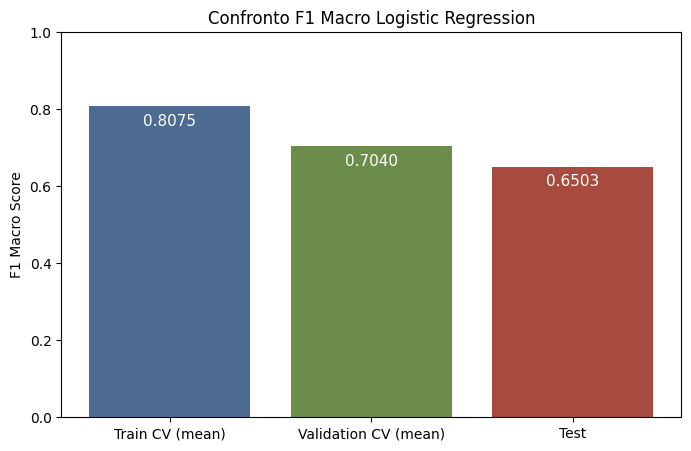

In [ ]:
#Calcolo F1 macro sul training set
y_train_pred = best_lr.predict(X_train_aug)
f1_train = f1_score(y_train_aug, y_train_pred, average='macro')

# Calcola F1 macro con cross-validation sul training set
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
cv_results = cross_validate(
    best_lr,
    X_train_aug,
    y_train_aug,
    cv=cv,
    scoring='f1_macro',
    return_train_score=True,
    n_jobs=-1
)
f1_train_cv_mean = cv_results['train_score'].mean()
f1_val_cv_mean = cv_results['test_score'].mean()

# Calcolo F1 macro sul test set
y_test_pred = best_lr.predict(X_test)
f1_test = f1_score(y_test, y_test_pred, average='macro')

# Dati per il grafico
labels = ['Train CV (mean)', 'Validation CV (mean)', 'Test']
scores = [f1_train_cv_mean, f1_val_cv_mean, f1_test]

# Plot
plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['#4C6A92', '#6C8C4B', '#A64B3D'])
plt.ylim(0,1)
plt.ylabel('F1 Macro Score')
plt.title('Confronto F1 Macro Logistic Regression')

# leggenda
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height - 0.05, f'{height:.4f}', ha='center', color='white', fontsize=11)

plt.show()


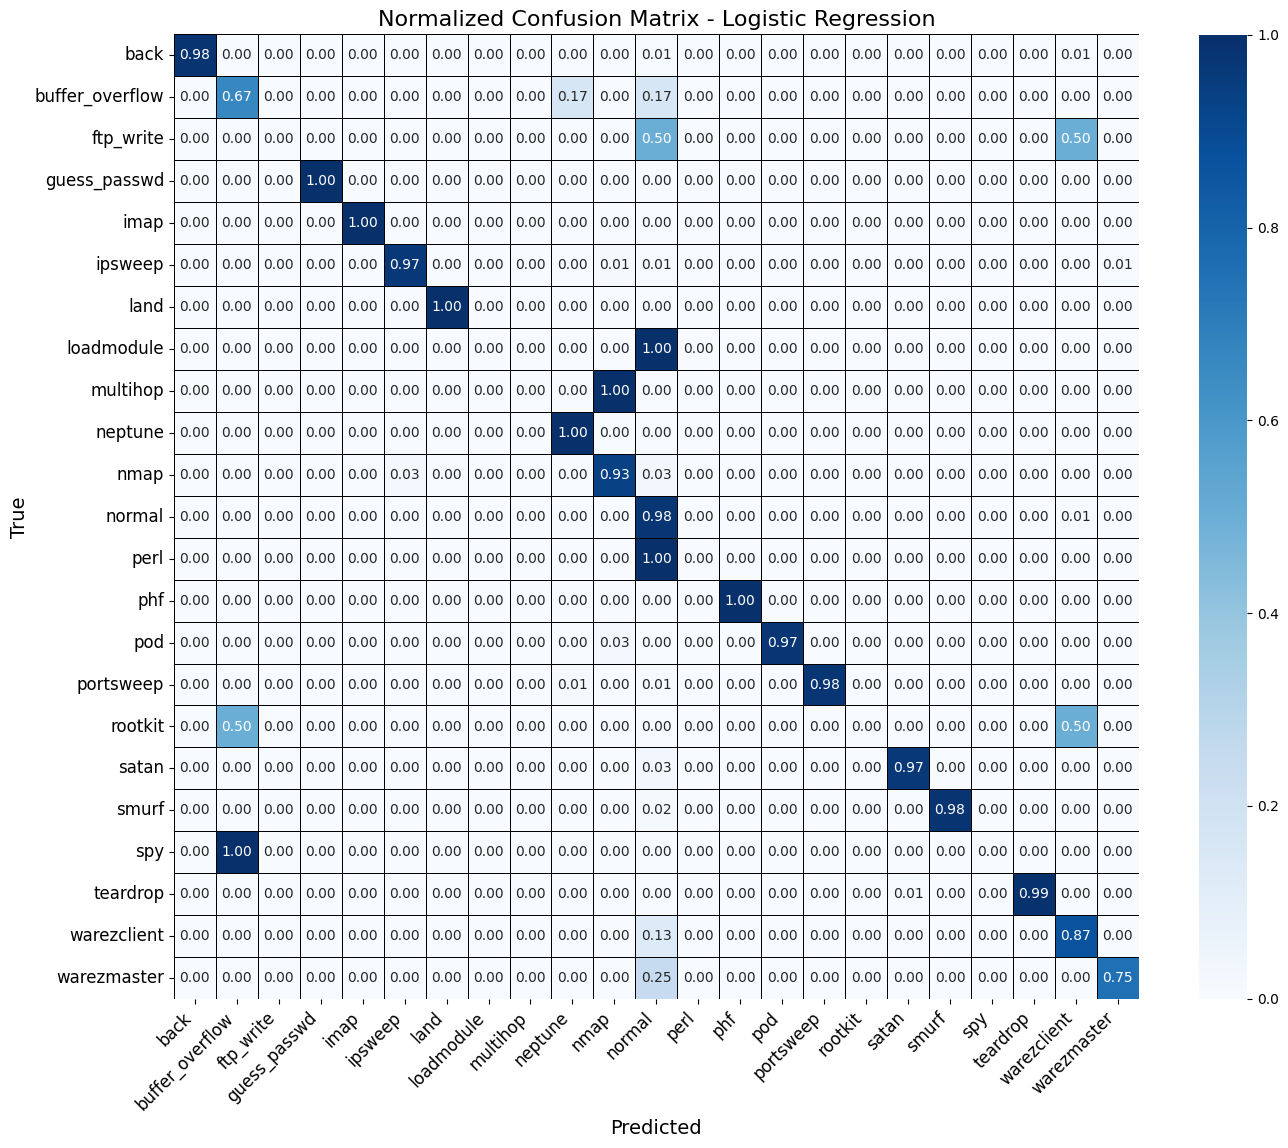

In [ ]:

# Calcolo le predizioni su test
y_pred = best_lr.predict(X_test)


class_names = best_lr.classes_

# Calcolo matrice di confusione
cm = confusion_matrix(y_test, y_pred, labels=class_names)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            annot_kws={'size': 10},
            cbar_kws={'shrink': 0.91},
            linewidths=0.5, linecolor='black',
            square=True)

plt.title("Normalized Confusion Matrix - Logistic Regression", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()


# CNN

**Metrica di valutazione F1 Macro**

Viene definita la metrica di valutazione del modello che prevede l'utilizzo dell'F1Score di keras adattandola nella sua versione con label intere e non codificate tramite one hot encoding; prima del calcolo le predizioni vengono infatti convertite nel giusto formato.

In [ ]:
# funzione per metrica F1-macro per etichette sparse, convertendo y_true in one-hot
def sparse_f1_macro(num_classes):

    f1 = tf.keras.metrics.F1Score(average='macro', name='f1_macro')

    def _metric(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
        return f1(y_true, y_pred)           # usa lo stato interno di `f1`
    _metric.__name__ = 'f1_macro'        
    return _metric

**Callback per il training**

early_f1: istanza di EarlyStopping che interrompe l’allenamento se per 15 epoche consecutive il valore di validazione di Macro F1 (val_f1_macro) non migliora. Alla fine ripristina i pesi del modello che hanno ottenuto il miglior F1 e segnala via log quando avviene l’arresto.

In [ ]:
early_f1 = callbacks.EarlyStopping(
    monitor='val_f1_macro', mode='max', patience=15,
    restore_best_weights=True, verbose=1
)

**Funzione di Loss**

La funzione `sparse_focal_loss` internamente utilizza la `CategoricalFocalCrossentropy` di Keras, adattandola a label intere anziché one-hot. La funzione converte infatti le etichette sparse in vettori one-hot, consentendo il calcolo effettivo della focal loss per mitigare l’impatto delle classi sbilanciate, aumentando il peso degli errori su esempi difficili come le classi minoritarie.

gamma (γ): esponente che regola quanto penalizzare gli esempi facili. Valori maggiori di γ aumentano la concentrazione sugli esempi “hard”.

alpha (α): peso scalare che bilancia l’importanza globale della componente focale.

In [ ]:


def sparse_focal_loss(gamma, alpha, from_logits=False):
  
    # crea il loss Keras multiclasse
    cat_focal = tf.keras.losses.CategoricalFocalCrossentropy(
        gamma=gamma,
        alpha=alpha,
        from_logits=from_logits,
        name="sparse_focal_loss"
    )

    #  definisci la funzione loss vera e propria
    def loss_fn(y_true, y_pred):
        # cast ad int e one-hot
        y_true = tf.cast(y_true, tf.int32)
        y_true_oh = tf.one_hot(y_true, depth=23)
        # delega al loss Keras
        return cat_focal(y_true_oh, y_pred)

   
    loss_fn.__name__ = "sparse_focal_loss"
    return loss_fn


Qui sotto viene definita una funzione per il print delle performance del modello trainato andando a stampare il report sulla varie classi, l'andamento della loss rispetto al training set e rispetto alla validation set sulle varie epoche ed un secondo plot con l'andamento della Macro F1

In [ ]:
def performance(history, model):
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    report_cross = classification_report(y_test, y_pred, digits=6,
                                         target_names=label_encoder.classes_)
    print(report_cross)

    #  loss 
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'],     label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val   Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # F1-macro 
    plt.figure(figsize=(6,4))
    plt.plot(history.history['f1_macro'],     label='Train F1-Macro')
    plt.plot(history.history['val_f1_macro'], label='Val   F1-Macro')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Macro')
    plt.title('Training vs Validation F1-Macro')
    plt.legend()
    plt.tight_layout()
    plt.show()


**Input della CNN**

Il codice genera una visualizzazione per ciascuna delle 23 classi presenti nel dataset di training. Per ogni classe viene selezionato un sample e mostrato la sua immagine corrispondente e rappresentata tramite una mappa di intensità cromatica. Questi subplot offrono un'intuzione qualitativa dell'input della CNN, permettendo di cogliere la diversità delle classi.

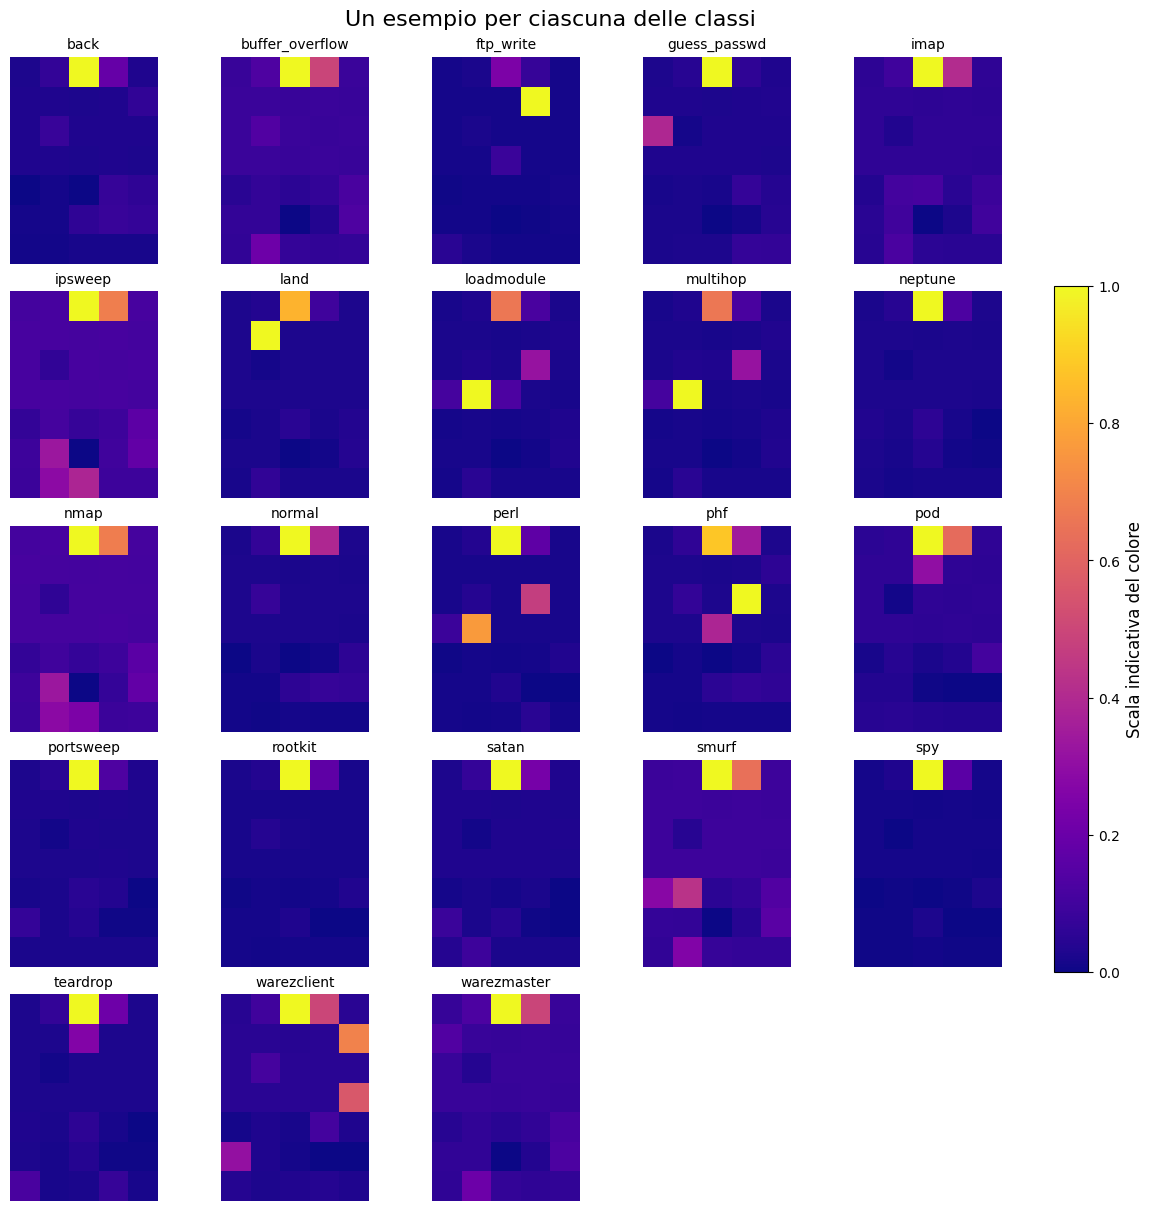

In [ ]:
fig, axes = plt.subplots(
    nrows=5, ncols=5,
    figsize=(12, 12),
    constrained_layout=True
)
axes = axes.flat

# Disegna ogni immagine con auto-scaling
for cls in range(23):
    if isinstance(y_train, np.ndarray):
        idx = np.where(y_train == cls)[0][0]
    else:
        idx = y_train[y_train == cls].index[0]

    row = (X_train.iloc[idx].to_numpy()
           if not isinstance(X_train, np.ndarray)
           else X_train[idx])
    img = row.reshape((7, 5))

    class_name = label_encoder.classes_[cls]

    ax = axes[cls]
    im = ax.imshow(img, cmap='plasma')  # auto-vmin/vmax
    ax.set_title(class_name, fontsize=10)
    ax.axis('off')

# Nascondi subplot vuoti
for ax in axes[23:]:
    ax.axis('off')

# Colorbar indicativa
sm = ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])  # necessario per la compatibilità con colorbar
cbar = fig.colorbar(sm, ax=axes[:23], shrink=0.6, orientation='vertical')
cbar.set_label('Scala indicativa del colore', fontsize=12)

# Titolo 
fig.suptitle("Un esempio per ciascuna delle classi", fontsize=16)

plt.show()


**Architettura e addestramento della CNN**

Il modello implementato si ispira all’architettura classica di LeNet-5, opportunamente adattata per dati tabellari convertiti in tensori di dimensione 7×5 con un singolo canale tramite il layer di **Reshape**.

L’architettura prevede tre blocchi convoluzionali sequenziali, ciascuno composto da un layer Conv2D (con kernel 3×3, padding “same”), seguito da Batch Normalization, funzione di attivazione ReLU e MaxPooling 2×2.

L'output dei layer convoluzionali viene mandato ad un layer di Global Average Pooling che adatta il dato per i layer successivi.

Seguono due layer densi intermedi, entrambi accompagnati da Batch Normalization, attivazione ReLU e dropout per ridurre l’overfitting.

Il layer finale utilizza una funzione di attivazione **softmax** per produrre una distribuzione di probabilità su 23 classi.

Per l’ottimizzazione si è scelto l’algoritmo Adam con uno scheduler di learning rate a decadimento coseno con epoche di warm-up, in modo da garantire una convergenza più stabile e veloce. La funzione di perdita adottata è una **categorical_focal_loss** adattata al problema sparso, mentre la metrica principale è la F1 macro.



Model: "reg_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 7, 5, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 5, 16)       │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 7, 5, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 7, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 3, 32)       │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 4, 3, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 4, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 2, 2, 64)       │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             

 Total params: 77,287 (301.90 KB)

 Trainable params: 76,295 (298.03 KB)

 Non-trainable params: 992 (3.88 KB)

Epoch 1/150
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - f1_macro: 0.1409 - loss: 0.5951 - val_f1_macro: 0.4738 - val_loss: 0.0496
Epoch 2/150
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - f1_macro: 0.5044 - loss: 0.0566 - val_f1_macro: 0.5363 - val_loss: 0.0407
Epoch 3/150
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - f1_macro: 0.5268 - loss: 0.0438 - val_f1_macro: 0.6164 - val_loss: 0.0341
Epoch 4/150
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - f1_macro: 0.6000 - loss: 0.0369 - val_f1_macro: 0.5871 - val_loss: 0.0309
Epoch 5/150
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - f1_macro: 0.6479 - loss: 0.0322 - val_f1_macro: 0.6248 - val_loss: 0.0279
Epoch 6/150
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - f1_macro: 0.6495 - loss: 0.0284 - val_f1_macro: 0.6157 - val_loss: 0.0241
Epoch 7/150
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - f1_macro: 0.6517 - loss: 0.0247 - val_f1_macro: 0.6406 - val_loss: 0.0220
Epoch 8/150
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - f1_macro: 0.6815 - loss: 0.0216 - val_f1_m

c:\Users\edoar\OneDrive\Desktop\Machine_Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\edoar\OneDrive\Desktop\Machine_Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\edoar\OneDrive\Desktop\Machine_Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

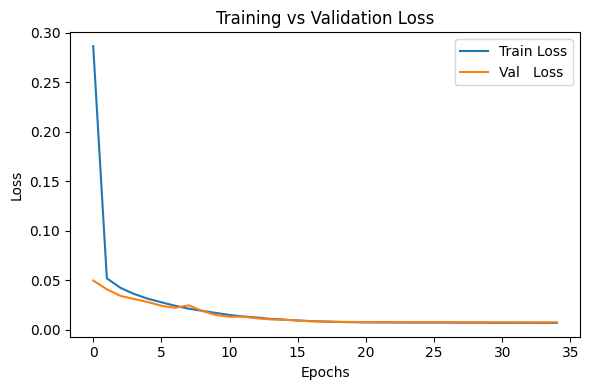

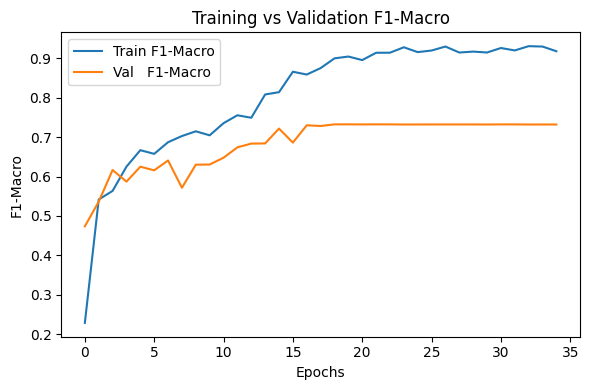

In [ ]:

model = Sequential([
    # Input e reshape
    layers.Input(shape=(35,)),
    layers.Reshape((7, 5, 1)),
    
    # Primo blocco conv + BN + ReLU + pooling
    layers.Conv2D(16, (3,3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2), padding='same'),
    
    # Secondo blocco conv + BN + ReLU + pooling
    layers.Conv2D(32, (3,3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2), padding='same'),
    
    # Terzo blocco conv + BN + ReLU + pooling
    layers.Conv2D(64, (3,3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2), padding='same'),
    
    # Flatten + Dense1 + BN + ReLU + Dropout
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, use_bias=False, kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),
    layers.Dropout(0.1),
    
    # Dense2 + BN + ReLU + Dropout
    layers.Dense(128, use_bias=False, kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),
    layers.Dropout(0.1),
    
    # Output softmax
    layers.Dense(23, activation='softmax')
], name='reg_CNN')

model.summary()

# parametri base
BATCH_SIZE    = 128
steps_per_epoch = int(np.ceil(len(X_train) / BATCH_SIZE))

lr_schedule = CosineDecay(
    initial_learning_rate=5e-4,               # lr di partenza del warm-up (qui 0)
    decay_steps=steps_per_epoch * 20,        # durata della fase cosine
    alpha=1e-2,                              # frazione finale di lr: final_lr = initial_lr * alpha
    warmup_target=5e-4,                      # lr “di picco” a fine warm-up
    warmup_steps=2 * steps_per_epoch,        # numero di step di warm-up
    name="lr_warmup_cosine"
)


optimizer = Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss=sparse_focal_loss(gamma=2.0, alpha=alpha_vec, from_logits=False),
    metrics=[sparse_f1_macro(23)]
)


history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_f1],
    verbose=1
)

performance(history, model)

**KERAS TURNER**

Iperparametri di tuning:

* Il numero di filtri nei tre blocchi convoluzionali (`filters_1`, `filters_2`, `filters_3`)
* Il parametro `gamma` della focal loss
* Il learning rate iniziale (`learning_rate`)
* Il numero di unità nei due layer densi (`dense1_units` e `dense2_units`)
* I tassi di dropout associati ai layer densi (`dropout_1` e `dropout_2`)
* Il parametro `clipnorm` che limita la norma del gradiente durante l’ottimizzazione, utile per stabilizzare l’addestramento prevenendo gradienti esplosivi.
* La durata del decadimento del learning rate (`decay_epochs`)

La ricerca degli iperparametri viene condotta tramite Random Search, con un massimo di 10 configurazioni esplorate, ognuna ripetuta 3 volte per garantirne la robustezza, monitorando la metrica di validazione F1 macro.

Al termine del processo, vengono identificati e selezionati i migliori iperparametri, che costituiscono la configurazione ottimale per la CNN da utilizzare nelle fasi successive di valutazione e test.


In [ ]:

BATCH_SIZE = 128
def build_model(hp):
    # Hyperparametri da esplorare
    # Conv blocks: num filtri & kernel size
    f1 = hp.Int("filters_1",  8,  32,  step=8,  default=16)
    f2 = hp.Int("filters_2", 16, 64,  step=16, default=32)
    f3 = hp.Int("filters_3", 32, 128,  step=32, default=64)

    # Focal loss params
    gamma = hp.Float("gamma", 0.5, 2, step=0.5, default=2.0)

    # Optimizer 
    init_lr      = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    # Layer densi
    dense1_units = hp.Int("dense1_units", 128, 512, step=128, default=256)
    dense2_units = hp.Int("dense2_units",  64, 256, step=64,  default=128)
    dropout_1    = hp.Float("dropout_1", 0.05, 0.2, step=0.05, default=0.05)
    dropout_2    = hp.Float("dropout_2", 0.05, 0.2, step=0.05, default=0.05)
    clipnorm     = hp.Float("clipnorm", 0.5, 2.0, step=0.5, default=1.0)



    # Warm-up & decay multipliers in epoche
    decay_epochs  = hp.Int("decay_epochs", 10, 40, step=10, default=20)

    # Costruzione del modello
    model = Sequential([
        layers.Input(shape=(35,)),
        layers.Reshape((7,5,1)),

        layers.Conv2D(f1, (3,3), padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(5e-4)),
        layers.BatchNormalization(momentum=0.9),
        layers.Activation("relu"),
        layers.MaxPooling2D((2,2), padding="same"),

        layers.Conv2D(f2, (3,3), padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(5e-4)),
        layers.BatchNormalization(momentum=0.9),
        layers.Activation("relu"),
        layers.MaxPooling2D((2,2), padding="same"),

        layers.Conv2D(f3, (3,3), padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(5e-4)),
        layers.BatchNormalization(momentum=0.9),
        layers.Activation("relu"),
        layers.MaxPooling2D((2,2), padding="same"),

        layers.GlobalAveragePooling2D(),
        layers.Dense(dense1_units, use_bias=False,
                     kernel_regularizer=regularizers.l2(5e-4)),
        layers.BatchNormalization(momentum=0.9),
        layers.Activation("relu"),
        layers.Dropout(dropout_1),

        layers.Dense(dense2_units, use_bias=False,
                     kernel_regularizer=regularizers.l2(5e-4)),
        layers.BatchNormalization(momentum=0.9),
        layers.Activation("relu"),
        layers.Dropout(dropout_2),

        layers.Dense(23, activation="softmax")
    ], name='CNN')

    # Learning-rate schedule con warm-up e cosine-decay
    steps = int(np.ceil(len(X_train) / BATCH_SIZE))
    warmup_steps = steps
    decay_steps  = decay_epochs  * steps

    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=init_lr,
        decay_steps=decay_steps,
        alpha=1e-2,
        warmup_target=init_lr,
        warmuo_steps=warmup_steps,
        name="lr_warmup_cosine"
    )
    optimizer = Adam(learning_rate=lr_schedule, clipnorm=clipnorm) #uso adam

    # Compilazione
    model.compile(
        optimizer=optimizer,
        loss=sparse_focal_loss(gamma=gamma, alpha=alpha_vec, from_logits=False),
        metrics=[sparse_f1_macro(23)]
    )
    return model

BATCH_SIZE = 128


# RandomSearch
tuner_CNN = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_f1_macro", direction="max"),
    max_trials=10,
    executions_per_trial=3,
    directory="kt_tuning",
    project_name="CNN_tuning",
    seed=42
)

early_f1 = EarlyStopping(
    monitor='val_f1_macro',
    patience=15,
    mode='max',
    restore_best_weights=True
)

# Avvio la ricerca
tuner_CNN.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=BATCH_SIZE,
    callbacks=[early_f1],
    verbose=1
)

# Migliori iperparametri
best_hps = tuner_CNN.get_best_hyperparameters(1)[0]
print("Best hyperparameters:", best_hps.values)


Reloading Tuner from kt_tuning\CNN_tuning\tuner0.json
Best hyperparameters: {'filters_1': 24, 'filters_2': 64, 'filters_3': 32, 'gamma': 2.0, 'learning_rate': 0.001, 'dense1_units': 384, 'dense2_units': 64, 'dropout_1': 0.1, 'dropout_2': 0.1, 'clipnorm': 2.0, 'decay_epochs': 20}


Questo codice definisce e addestra nuovamente un modello CNN utilizzando i migliori iperparametri individuati nella fase di tuning.

Infine, la funzione `performance` visualizza e analizza l’andamento del training.

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_8 (Reshape)             │ (None, 7, 5, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 7, 5, 24)       │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 7, 5, 24)       │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 7, 5, 24)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 4, 3, 24)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 4, 3, 64)       │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 4, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 4, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 2, 2, 32)       │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 2, 2, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 384)            │        12,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 384)            │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_44 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             

 Total params: 73,103 (285.56 KB)

 Trainable params: 71,967 (281.12 KB)

 Non-trainable params: 1,136 (4.44 KB)

Epoch 1/150
657/657 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - f1_macro: 0.2307 - loss: 2.2256 - val_f1_macro: 0.4503 - val_loss: 0.3821
Epoch 2/150
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - f1_macro: 0.5280 - loss: 0.2683 - val_f1_macro: 0.5252 - val_loss: 0.2085
Epoch 3/150
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - f1_macro: 0.5885 - loss: 0.1964 - val_f1_macro: 0.5034 - val_loss: 0.2260
Epoch 4/150
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - f1_macro: 0.6059 - loss: 0.1747 - val_f1_macro: 0.6143 - val_loss: 0.2176
Epoch 5/150
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - f1_macro: 0.6267 - loss: 0.1536 - val_f1_macro: 0.6191 - val_loss: 0.1456
Epoch 6/150
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - f1_macro: 0.6649 - loss: 0.1395 - val_f1_macro: 0.6340 - val_loss: 0.1314
Epoch 7/150
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - f1_macro: 0.7050 - loss: 0.1155 - val_f1_macro: 0.6056 - val_loss: 0.1288
Epoch 8/150
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - f1_macro: 0.7030 - loss: 0.1183 -

c:\Users\Edoardo\Desktop\ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Edoardo\Desktop\ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Edoardo\Desktop\ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


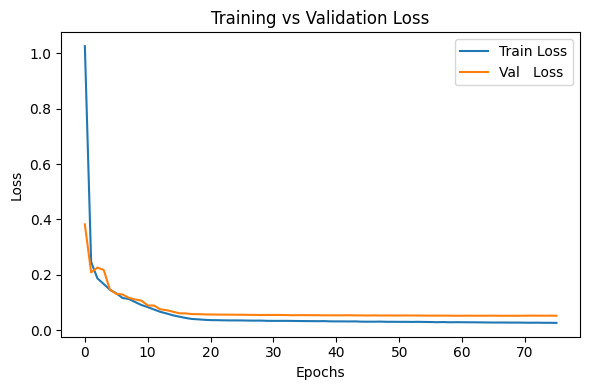

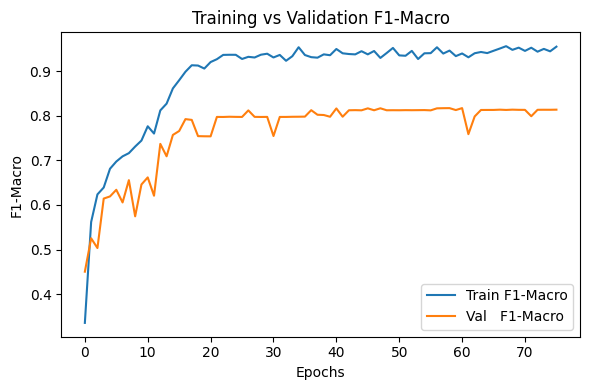

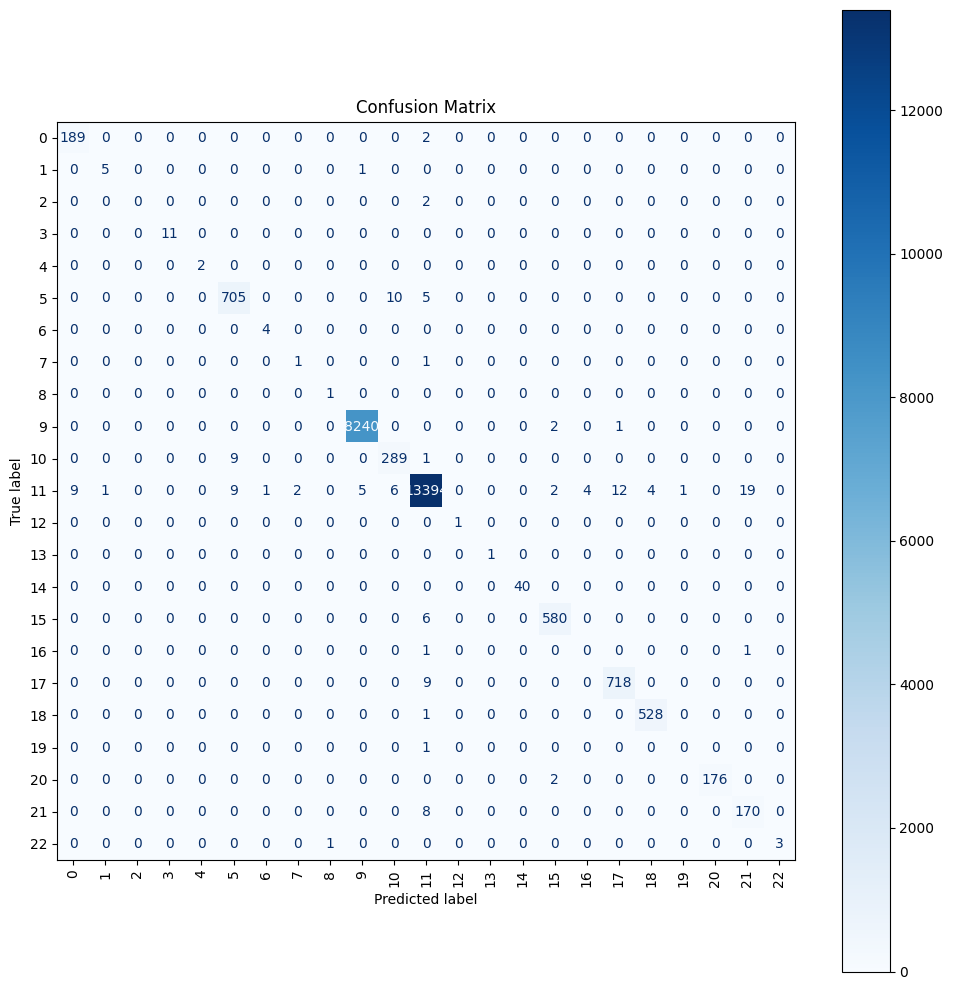

In [ ]:
#uso i migliori iperparma
model = Sequential([
    # Input e reshape
    layers.Input(shape=(35,)),
    layers.Reshape((7, 5, 1)),
    
    # Primo blocco conv + BN + ReLU + pooling
    layers.Conv2D(24, (3,3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(5e-4)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2), padding='same'),
    
    # Secondo blocco conv + BN + ReLU + pooling
    layers.Conv2D(64, (3,3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(5e-4)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2), padding='same'),
    
    # Terzo blocco conv + BN + ReLU + pooling
    layers.Conv2D(32, (3,3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(5e-4)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2), padding='same'),
    
    # Flatten + Dense1 + BN + ReLU + Dropout
    layers.GlobalAveragePooling2D(),
    layers.Dense(384, use_bias=False, kernel_regularizer=regularizers.l2(5e-4)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),
    layers.Dropout(0.1),
    
    # Dense2 + BN + ReLU + Dropout
    layers.Dense(64, use_bias=False, kernel_regularizer=regularizers.l2(5e-4)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),
    layers.Dropout(0.1),
    
    # Output softmax
    layers.Dense(23, activation='softmax')
], name= 'CNN')

model.summary()

# parametri base
BATCH_SIZE    = 128
steps_per_epoch = int(np.ceil(len(X_train) / BATCH_SIZE))


lr_schedule = CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=steps_per_epoch * 20,
    alpha=1e-2
    warmup_target=0.001,
    warmup_steps=2 * steps_per_epoch,
    name="lr_warmup_cosine"
)

optimizer = Adam(learning_rate=lr_schedule, clipnorm=2.0)

model.compile(
    optimizer=optimizer,
    loss=sparse_focal_loss(gamma=2.0, alpha=alpha_vec),
    metrics=[sparse_f1_macro(23)]
)


history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_f1],
    verbose=1
)

performance(history, model)

**Performance finali della CNN**

Infine vengono visualizzate tramite la matrice di confusione normalizzata ed un grafico a barre le performance della rete neurale.

788/788 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


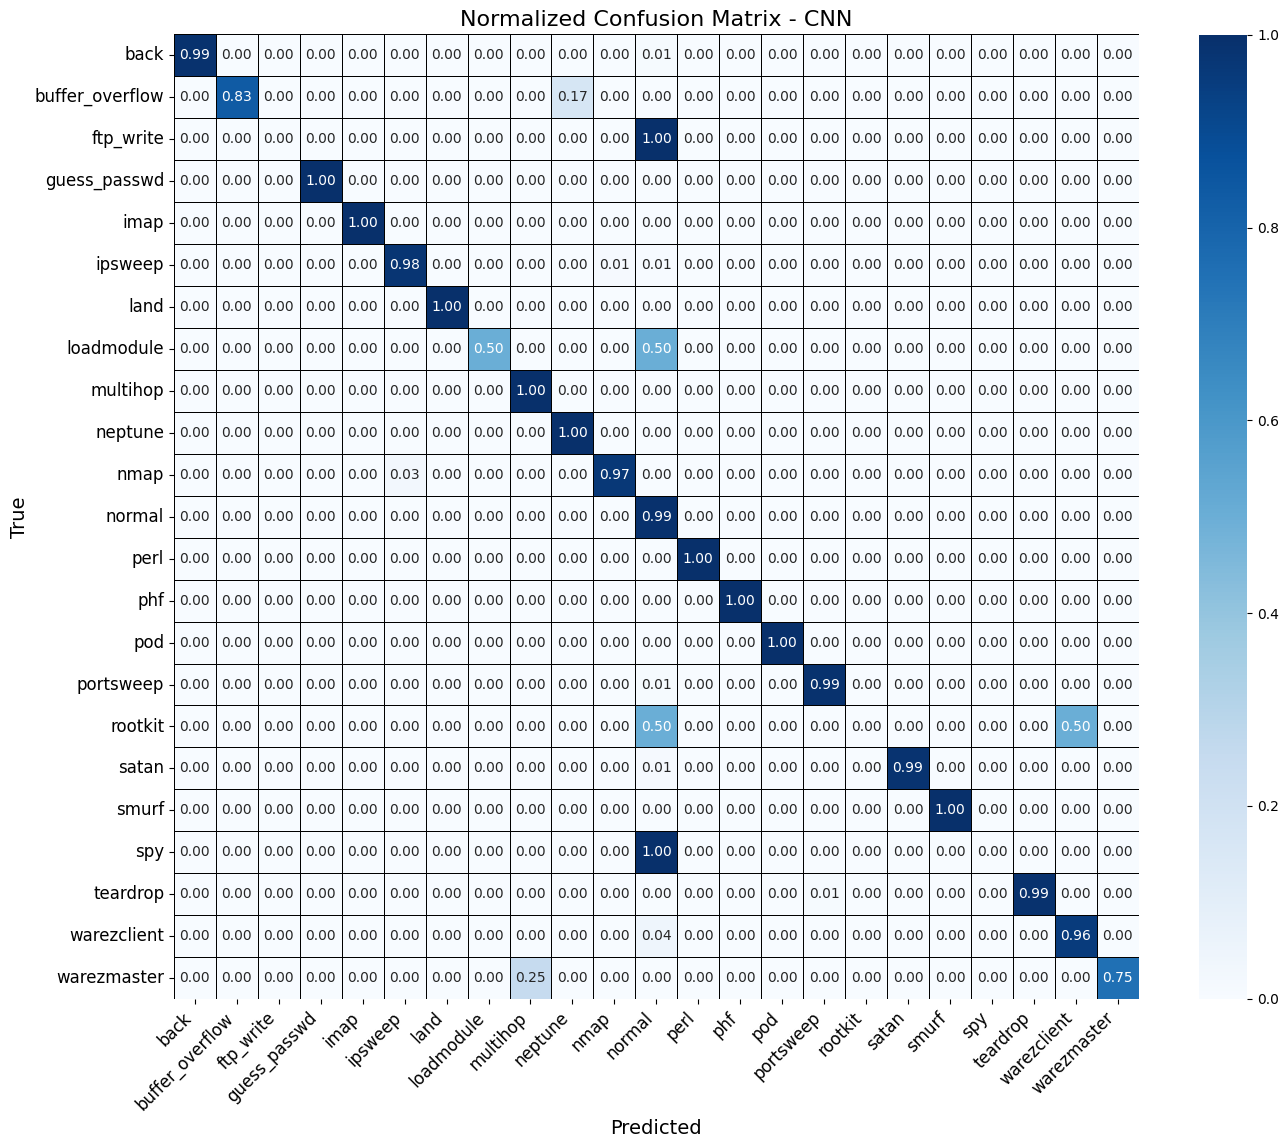

In [ ]:
# Decodifico le etichette one-hot encoded
y_pred_prob = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)
cnn_predictions = label_encoder.inverse_transform(y_pred)
y_true = label_encoder.inverse_transform(y_test[:len(y_pred)])

# Calcolo la matrice di confusione con tutte le classi
cm = confusion_matrix(y_true, cnn_predictions, labels=label_encoder.classes_)

# Calcolo la matrice di confusione normalizzata
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            annot_kws={'size': 10},
            cbar_kws={'shrink': 0.91},
            linewidths=0.5, linecolor='black',
            square=True)

plt.title("Normalized Confusion Matrix - CNN", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()


2627/2627 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


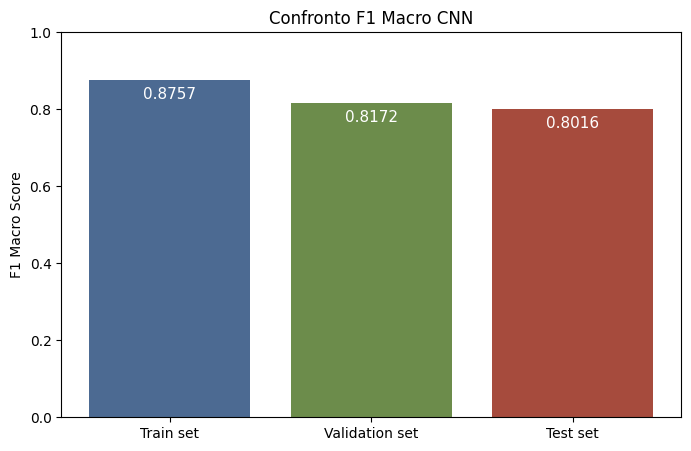

In [ ]:
# Funzione helper per predire classi da modello Keras
def predict_classes(model, X):
    y_probs = model.predict(X)
    return np.argmax(y_probs, axis=1)

# Calcolo F1 macro sul training set completo
y_train_pred = predict_classes(model, X_train)
f1_train = f1_score(y_train, y_train_pred, average='macro')
# Calcolo F1 macro sul validation set completo
y_val_pred = predict_classes(model, X_val)
f1_val = f1_score(y_val, y_val_pred, average='macro')
# Calcolo F1 macro sul test set
y_test_pred = predict_classes(model, X_test)
f1_test = f1_score(y_test, y_test_pred, average='macro')

# Dati 
labels = ['Train set', 'Validation set', 'Test set']
scores = [f1_train, f1_val, f1_test]

# Plot
plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['#4C6A92', '#6C8C4B', '#A64B3D'])
plt.ylim(0,1)
plt.ylabel('F1 Macro Score')
plt.title('Confronto F1 Macro CNN')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height - 0.05, f'{height:.4f}', ha='center', color='white', fontsize=11)

plt.show()


# Confronto performance dei modelli

In [ ]:
def predict_cnn_classes(model, X):
    y_probs = model.predict(X)
    return np.argmax(y_probs, axis=1)

# Funzione per ottenere predizioni da modelli sklearn o pipeline
def predict_sklearn(model, X):
    return model.predict(X)

# Calcola metriche per ogni modello 
def compute_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1 Macro': f1_score(y_true, y_pred, average='macro', zero_division=0), #zero div sempre per warning
        'Precision Macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Recall Macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
    }

# Predizioni
y_pred_rf = predict_sklearn(best_rf, X_test)
y_pred_lr = predict_sklearn(best_lr, X_test)
y_pred_cnn = predict_cnn_classes(model, X_test)

# Metriche
metrics_rf = compute_metrics(y_test, y_pred_rf)
metrics_lr = compute_metrics(y_test, y_pred_lr)
metrics_cnn = compute_metrics(y_test, y_pred_cnn)

# Costruisco dataframe
df_compare = pd.DataFrame({
    'Random Forest': metrics_rf,
    'Logistic Regression': metrics_lr,
    'CNN': metrics_cnn,
}).T.round(6)


# Titolo
print("\n" + "="*70)
print(" \t\tConfronto metriche modelli su test set ")
print("="*70 + "\n")

# tabella
print(df_compare.to_string().replace('\n', '\n\n'))

print("\n" + "="*70 + "\n")


788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

 		Confronto metriche modelli su test set 

                     Accuracy  F1 Macro  Precision Macro  Recall Macro

Random Forest        0.998135  0.793731         0.814335      0.783553

Logistic Regression  0.984005  0.650339         0.625007      0.697683

CNN                  0.994483  0.801645         0.791498      0.823128




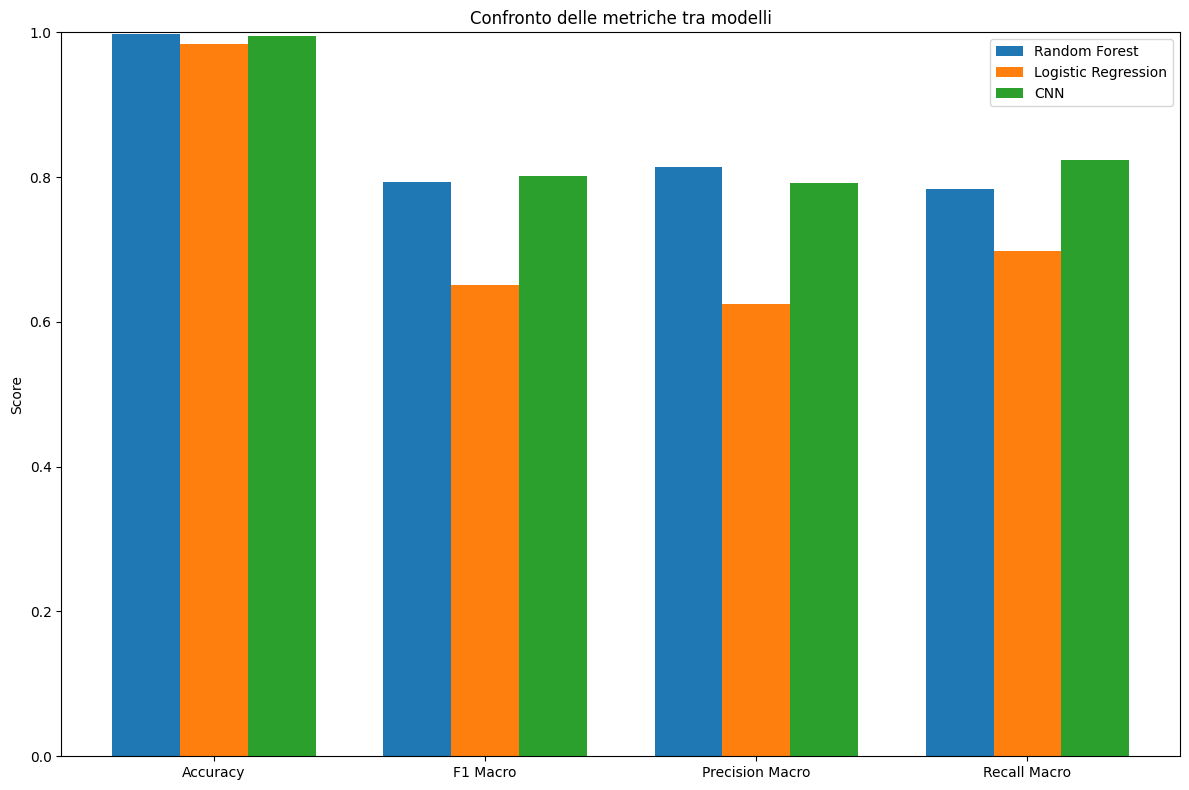

In [ ]:
metrics = ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro']
models = df_compare.index.tolist()  
values = df_compare.values  # shape (n_modelli, n_metriche)

x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(12,8))

for i, model_name in enumerate(models):
    ax.bar(x + i*width, values[i], width, label=model_name)

ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.set_ylim(0,1)
ax.set_ylabel('Score')
ax.set_title('Confronto delle metriche tra modelli')
ax.legend()



plt.tight_layout()
plt.show()



---

## Conclusioni
**Approcci implementati**

* **Random Forest** + SMOTENC + class\_weight
* **Logistic Regression** + SMOTENC + espansione polinomiale (grado 2)
* **CNN** con reshaping 7×5, conv2D, batch-norm, pooling e regolarizzazione L₂

**Risultati chiave (Test set)**

* **CNN**: F1-macro ≈ 0.80 → miglior generalizzazione
* **Random Forest**: F1-macro ≈ 0.76 → ottimo training ma overfitting (gap train-valid ampio)
* **Logistic Regression**: F1-macro ≈ 0.65 → interpretabile ma troppo lineare

**Conclusioni finale**

1. **SMOTENC + class\_weight** bilanciano il dataset, ma servono strategie mirate per le classi rarissime.
2. **Espansione polinomiale** abilita la LR a cogliere interazioni non lineari con costi computazionali contenuti.
3. **CNN** offre il miglior compromesso bias-variance su dati sintetizzati e reali.


**Possibili Future Implementazioni**

1. **Espansione Polinomiale di Grado Superiore**

   * Passare a `degree=3` o 4 per catturare interazioni di ordine più alto e pattern complessi.
   * Richiede più memoria e tempo di calcolo, ma può rivelarsi efficace se supportato da hardware con più RAM o GPU.

2. **Ottimizzazione delle Soglie di Decisione**

   * Si potrebbe calibrare una soglia diversa per ciascuna classe massimizzando la F1 o il recall.

---

